In [1]:
library(SingleCellExperiment)
library(ggplot2)
library(multinichenetr)
library(nichenetr)
library(Seurat)
library(tidyverse)
library(data.table)
library(dplyr)
library(rjson)
options(warn=-1)

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

In [2]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /home/analysis/miniconda3/envs/scPipe/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.utf-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.utf-8        LC_COLLATE=en_US.utf-8    
 [5] LC_MONETARY=en_US.utf-8    LC_MESSAGES=en_US.utf-8   
 [7] LC_PAPER=en_US.utf-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.utf-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] rjson_0.2.21                data.table_1.15.2          
 [3] lubridate_1.9.2             forcats_1.0.0              
 [5] stringr_1.5.1               dplyr_1.1.4                
 [7] purrr_1.0.2                 readr_2.1.4                
 [9] tidyr_1.3.1                 tibble_3.2.

# Download LR database and save to local

In [3]:
# organism = "human"
# options(timeout = 250)

# if(organism == "human"){
  
#   lr_network_all = 
#     readRDS(url(
#       "https://zenodo.org/record/10229222/files/lr_network_human_allInfo_30112033.rds"
#       )) %>% 
#     mutate(
#       ligand = convert_alias_to_symbols(ligand, organism = organism), 
#       receptor = convert_alias_to_symbols(receptor, organism = organism))
  
#   lr_network_all = lr_network_all  %>% 
#     mutate(ligand = make.names(ligand), receptor = make.names(receptor)) 
  
#   lr_network = lr_network_all %>% 
#     distinct(ligand, receptor)
  
#   ligand_target_matrix = readRDS(url(
#     "https://zenodo.org/record/7074291/files/ligand_target_matrix_nsga2r_final.rds"
#     ))
  
#   colnames(ligand_target_matrix) = colnames(ligand_target_matrix) %>% 
#     convert_alias_to_symbols(organism = organism) %>% make.names()
#   rownames(ligand_target_matrix) = rownames(ligand_target_matrix) %>% 
#     convert_alias_to_symbols(organism = organism) %>% make.names()
  
#   lr_network = lr_network %>% filter(ligand %in% colnames(ligand_target_matrix))
#   ligand_target_matrix = ligand_target_matrix[, lr_network$ligand %>% unique()]
  
# } else if(organism == "mouse"){
  
#   lr_network_all = readRDS(url(
#     "https://zenodo.org/record/10229222/files/lr_network_mouse_allInfo_30112033.rds"
#     )) %>% 
#     mutate(
#       ligand = convert_alias_to_symbols(ligand, organism = organism), 
#       receptor = convert_alias_to_symbols(receptor, organism = organism))
  
#   lr_network_all = lr_network_all  %>% 
#     mutate(ligand = make.names(ligand), receptor = make.names(receptor)) 
#   lr_network = lr_network_all %>% 
#     distinct(ligand, receptor)
  
#   ligand_target_matrix = readRDS(url(
#     "https://zenodo.org/record/7074291/files/ligand_target_matrix_nsga2r_final_mouse.rds"
#     ))
  
#   colnames(ligand_target_matrix) = colnames(ligand_target_matrix) %>% 
#     convert_alias_to_symbols(organism = organism) %>% make.names()
#   rownames(ligand_target_matrix) = rownames(ligand_target_matrix) %>% 
#     convert_alias_to_symbols(organism = organism) %>% make.names()
  
#   lr_network = lr_network %>% filter(ligand %in% colnames(ligand_target_matrix))
#   ligand_target_matrix = ligand_target_matrix[, lr_network$ligand %>% unique()]
  
# }

# lr_network_path = '../data/external/lr_network_human_allInfo_30112033.rds'
# ligand_target_matrix_path  = '../data/external/ligand_target_matrix_nsga2r_final.rds'
# saveRDS(lr_network, file=lr_network_path)
# saveRDS(ligand_target_matrix,file=ligand_target_matrix_path)

# Function defination

In [4]:
loadh5ad <- function(inh5ad) {
    library(reticulate)
    ad = import("anndata")
    data_ad = ad$read_h5ad(inh5ad)
    exp.rawdata = data_ad$X
    obs = as.data.frame(data_ad$obs)
    rownames(exp.rawdata) = data_ad$obs_names$to_list()
    colnames(exp.rawdata) = data_ad$var_names$to_list()
    exp.rawdata = t(exp.rawdata)
    return(list(counts=exp.rawdata,obs=obs))
}

getSampleShort <- function(name_list){ 
    sapply(name_list,function(x){paste0('P',paste(strsplit(x,'_')[[1]][c(3,4)],collapse  = '.'))})
           }

replaceChars <- function(name_list){
    name_list = gsub("[.+()-/]", "_", name_list)
    name_list = gsub("0_I", "R", name_list)
    name_list = gsub("II_III", "NR", name_list)
    return(gsub(" ", "_", name_list))
}

# Define parameters

### File path and celltype

In [5]:
COLOR_PAlETTE=fromJSON(file='../data/setting/ColorMap_R_sync.json')

In [6]:
lr_network_path = '../data/external/lr_network_human_allInfo_30112033.rds'
ligand_target_matrix_path  = '../data/external/ligand_target_matrix_nsga2r_final.rds'
sample_id = "Sample_Short"
celltype_id = "Celltype"
covariates = NA
batches = NA
obs_path = '../data/table/GEX_OBS_Cellstate.csv'
Object_Output_Folder = '../data/object/cell_interaction'
senders_oi = c("B","CAF","CD8T","Endothelial","Epithelial","Macs","Pericyte","Tumor")
receivers_oi =senders_oi

### Parameters for Cell type filtering

### minimum number of cells per cell type per sample at 10 (recommended minimum).

Samples that have less than min_cells cells will be excluded from the analysis for that specific cell type.

In [7]:
min_cells = 10

### Parameters for Gene filtering
For each cell type, we will consider genes expressed if they are expressed in at least a min_sample_prop fraction of samples in the condition with the lowest number of samples. By default, we set min_sample_prop = 0.50.

In [8]:
min_sample_prop = 0.50

For each cell type, we will consider genes expressed if they are expressed in at least a min_sample_prop fraction of samples in the condition with the lowest number of samples. By default, we set min_sample_prop = 0.50.

In [9]:
fraction_cutoff = 0.05 

###  Parameters for ligand activity prediction

We will here choose for applying the p-value cutoff on the normal p-values, and not on the p-values corrected for multiple testing. This choice was made here because this dataset has only a few samples per group and we might have a lack of statistical power due to pseudobulking.

In [10]:
logFC_threshold = 0.50
p_val_threshold = 0.05
p_val_adj = FALSE

After the ligand activity prediction, we will also infer the predicted target genes of these ligands in each contrast. For this ligand-target inference procedure, we also need to select which top n of the predicted target genes will be considered (here: top 250 targets per ligand). This parameter will not affect the ligand activity predictions. It will only affect ligand-target visualizations and construction of the intercellular regulatory network during the downstream analysis. We recommend users to test other settings in case they would be interested in exploring fewer, but more confident target genes, or vice versa.

In [11]:
top_n_target = 250

### Number of cores

In [12]:
cores_system = 8

### Parameters for prioritization

We will use the following criteria to prioritize ligand-receptor interactions:

- Upregulation of the ligand in a sender cell type and/or upregulation of the receptor in a receiver cell type - in the condition of interest.
- Cell-type specific expression of the ligand in the sender cell type and receptor in the receiver cell type in the condition of interest (to mitigate the influence of upregulated but still relatively weakly expressed ligands/receptors).
- Sufficiently high expression levels of ligand and receptor in many samples of the same group.
- High NicheNet ligand activity, to further prioritize ligand-receptor pairs based on their predicted effect of the ligand-receptor interaction on the gene expression in the receiver cell type.
  
We will combine these prioritization criteria in a single aggregated prioritization score. In the default setting, we will weigh each of these criteria equally (scenario = "regular"). This setting is strongly recommended. However, we also provide some additional setting to accomodate different biological scenarios. The setting scenario = "lower_DE" halves the weight for DE criteria and doubles the weight for ligand activity. This is recommended in case your hypothesis is that the differential CCC patterns in your data are less likely to be driven by DE (eg in cases of differential migration into a niche). The setting scenario = "no_frac_LR_expr" ignores the criterion "Sufficiently high expression levels of ligand and receptor in many samples of the same group". This may be interesting for users that have data with a limited number of samples and don’t want to penalize interactions if they are not sufficiently expressed in some samples.

In [13]:
scenario = "regular"

Finally, we still need to make one choice. For NicheNet ligand activity we can choose to prioritize ligands that only induce upregulation of target genes (ligand_activity_down = FALSE) or can lead potentially lead to both up- and downregulation (ligand_activity_down = TRUE). The benefit of ligand_activity_down = FALSE is ease of interpretability: prioritized ligand-receptor pairs will be upregulated in the condition of interest, just like their target genes. ligand_activity_down = TRUE can be harder to interpret because target genes of some interactions may be upregulated in the other conditions compared to the condition of interest. This is harder to interpret, but may help to pick up interactions that can also repress gene expression.

In [14]:
ligand_activity_down = FALSE

# Preprare Data

## Load ligand-receptor network database

In [15]:
lr_network = readRDS(lr_network_path)
ligand_target_matrix = readRDS(ligand_target_matrix_path)

## Celltype annotation data

In [16]:
celltype_col = celltype_id
obs = data.frame(fread(obs_path),row.names=1)
obs = obs %>% 
    mutate(Timepoint=replaceChars(Timepoint)) %>%
    mutate(Treatment_Arm=replaceChars(Treatment_Arm))%>%
    unite(BestResponse_Timepoint,c("br_short", "Timepoint"))
obs$Cellstate = replaceChars(obs[,celltype_col])
head(obs)

Sample_Short
GTATGTGGTCCTCCAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 P16.T4      
AACAAGCCAACAGGAT-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 P16.T4      
TTATAGCCATATAACC-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 P16.T4      
ATCACAATCCCTCTAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 P16.T4      
CCTCAAACAGGCATGA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 P16.T4      
AGTCAATGTCAATACG-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 P16.T4      
                                                      Sample          
GTATGTGGTCCTCCAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 CCG1112_16_T4_A1
AACAAGCCAACAGGAT-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 CCG1112_16_T4_A1
TTATAGCCATATAACC-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 CCG1112_16_T4_A1
ATCACAATCCCTCTAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 CCG1112_16_T4_A1
CCTCAAACAGGCATGA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 CCG1112_16_T4_A1
AGTCAATGTCAATACG-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 CCG1112_16_T4_A1
                                                      Compartment Lineage
GTATGTGGTCCTCCAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 Immune      Plasma 
AACAAGCCAACAGGAT-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 Immune      Myeloid
TTATAGCCATATAACC-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 Immune      Myeloid
ATCACAATCCCTCTAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 Immune      Myeloid
CCTCAAACAGGCATGA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 Immune      Myeloid
AGTCAATGTCAATACG-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 Immune      Myeloid
                                                      Celltype Cellstate
GTATGTGGTCCTCCAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 Plasma   Plasma   
AACAAGCCAACAGGAT-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 Macs     Macs     
TTATAGCCATATAACC-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 Macs     Macs     
ATCACAATCCCTCTAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 Macs     Macs     
CCTCAAACAGGCATGA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 Macs     Macs     
AGTCAATGTCAATACG-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 Macs     Macs     
                                                      CCG_ID          
GTATGTGGTCCTCCAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 CCG1112_16_T4_A1
AACAAGCCAACAGGAT-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 CCG1112_16_T4_A1
TTATAGCCATATAACC-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 CCG1112_16_T4_A1
ATCACAATCCCTCTAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 CCG1112_16_T4_A1
CCTCAAACAGGCATGA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 CCG1112_16_T4_A1
AGTCAATGTCAATACG-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 CCG1112_16_T4_A1
                                                      Tech                           
GTATGTGGTCCTCCAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 Multiome ATAC + Gene Expression
AACAAGCCAACAGGAT-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 Multiome ATAC + Gene Expression
TTATAGCCATATAACC-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 Multiome ATAC + Gene Expression
ATCACAATCCCTCTAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 Multiome ATAC + Gene Expression
CCTCAAACAGGCATGA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 Multiome ATAC + Gene Expression
AGTCAATGTCAATACG-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 Multiome ATAC + Gene Expression
                                                      WES_Profile
GTATGTGGTCCTCCAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 N          
AACAAGCCAACAGGAT-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 N          
TTATAGCCATATAACC-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 N          
ATCACAATCCCTCTAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 N          
CCTCAAACAGGCATGA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 N          
AGTCAATGTCAATACG-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 N          
                                                      BulkRNA_Profile PAM50
GTATGTGGTCCTCCAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 N               N/A  
AACAAGCCAACAGGAT-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 N               N/A  
TTATAGCCATATAACC-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 N               N/A  
ATCACAATCCCTCTAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 N               N/A  
CCTCAAACAGGCATGA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 N               N/A  
AGTCAATGTCAATACG-1_CCG1112_16_T4_A1_CCG111

## Load GEX h5ad data

In [17]:
h5ad_file = '../data/object/gex_all.h5ad'
data_list = loadh5ad(inh5ad =h5ad_file)
data_list$obs =  data_list$obs %>% 
    tibble::rownames_to_column(var="X") %>%
    left_join(obs %>% tibble::rownames_to_column(var='X'),by='X')%>%
    tibble::column_to_rownames(var='X')

## Create SCE object

In [18]:
sce_all = SingleCellExperiment(list(counts=data_list$counts),colData=data_list$obs)
sce_all

class: SingleCellExperiment 
dim: 36601 249459 
metadata(0):
assays(1): counts
rownames(36601): MIR1302-2HG FAM138A ... AC007325.4 AC007325.2
rowData names(0):
colnames(249459): CTCTAGCTCCGTGACA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1
  AGCGATTTCTATTGTC-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1 ...
  GGCTGGTTCGAATGCT-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1
  TCACAAGGTAATTGGA-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1
colData names(33): n_genes_by_counts log1p_n_genes_by_counts ...
  Patient Treatment_Arm
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [19]:
sce_all = alias_to_symbol_SCE(sce_all, "human") %>% makenames_SCE()

[1] "there are provided symbols that are not in the alias annotation table: "
    [1] "AL627309.1"       "AL627309.3"       "AL627309.2"      
    [4] "AL627309.5"       "AL627309.4"       "AP006222.2"      
    [7] "AL732372.1"       "AC114498.1"       "AL669831.2"      
   [10] "AL645608.6"       "AL645608.2"       "AL645608.4"      
   [13] "AL645608.7"       "AL645608.1"       "AL645608.5"      
   [16] "AL645608.8"       "AL390719.3"       "AL390719.2"      
   [19] "AL162741.1"       "AL139287.1"       "AL391244.2"      
   [22] "AL391244.1"       "AL645728.1"       "AL691432.4"      
   [25] "AL691432.2"       "FO704657.1"       "AL109917.1"      
   [28] "AL391845.2"       "AL391845.1"       "AL590822.2"      
   [31] "AL590822.1"       "AL590822.3"       "AL589739.1"      
   [34] "AL513477.2"       "AL139246.1"       "AL139246.4"      
   [37] "AL139246.5"       "AL139246.3"       "AL831784.1"      
   [40] "AC242022.2"       "AC242022.1"       "AL592464.2"      
   [43] "AL5

# Compare R vs NR in Baseline

In [20]:
group_id = "BestResponse_Timepoint"
compared_groups =  c("R_Baseline","NR_Baseline")

In [21]:
contrast = c(paste(compared_groups,collapse ='-'),
  paste(c(compared_groups[2],compared_groups[1]),collapse ='-')
 )
contrasts_oi = c(paste0("'",paste(contrast,collapse ="','"),"'"))
contrast_tbl = tibble(contrast =contrast,
                      group = compared_groups) 
contrasts_oi

[1] "'R_Baseline-NR_Baseline','NR_Baseline-R_Baseline'"

## Subset cells that are in senders and receiver cell type

In [22]:
sce = sce_all[, colData(sce_all)[,celltype_id] %in% c(senders_oi, receivers_oi)]
sce = sce[, colData(sce)[,group_id] %in% compared_groups]
sce

class: SingleCellExperiment 
dim: 36601 74819 
metadata(0):
assays(1): counts
rownames(36601): MIR1302.2HG FAM138A ... AC007325.4 AC007325.2
rowData names(0):
colnames(74819): CATTCATTCCCAGTAG-1_CCG1112_26_T1_B1_CCG1112_MO_Batch1
  ATGTGAGAGACAACAG-1_CCG1112_26_T1_B1_CCG1112_MO_Batch1 ...
  GCGAGAATCGTCCAGG-1_CCG1112_13_T1_A1_SN_5GEX_CCG1112_snRNA_Batch1
  AGAGTGGTCTAACCGA-1_CCG1112_13_T1_A1_SN_5GEX_CCG1112_snRNA_Batch1
colData names(33): n_genes_by_counts log1p_n_genes_by_counts ...
  Patient Treatment_Arm
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

## Perform MultiNicheNet’s cell-cell communication analysis

In [23]:
n.cores = min(cores_system, union(senders_oi, receivers_oi) %>% length()) # use one core per receiver cell type

#### Celltype-filtering

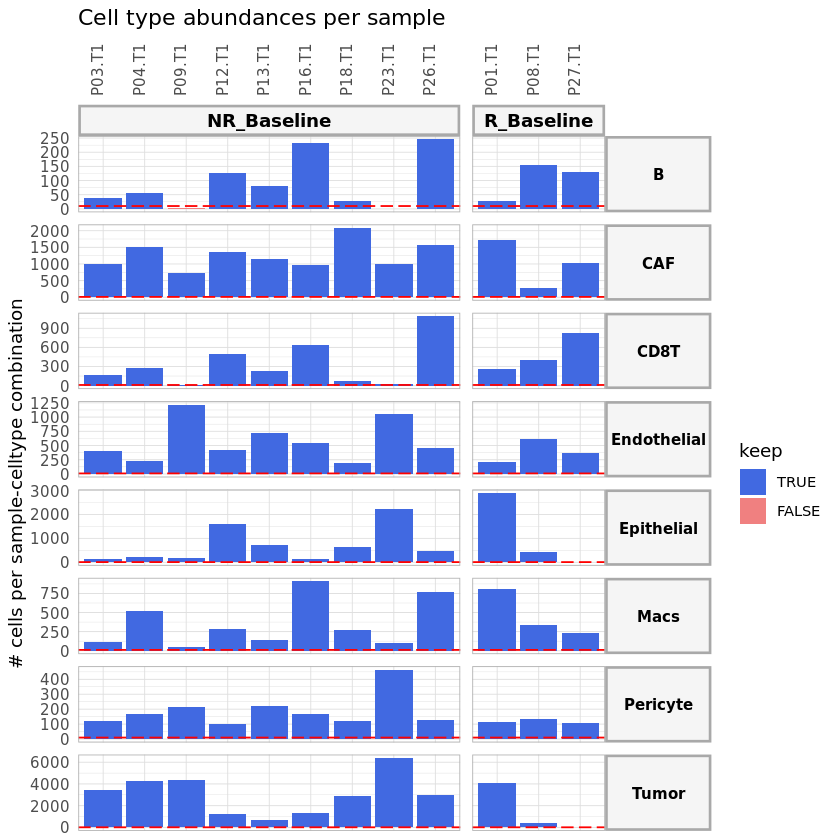

In [24]:
abundance_info = get_abundance_info(
  sce = sce, 
  sample_id = sample_id, group_id = group_id, celltype_id = celltype_id, 
  min_cells = min_cells, 
  senders_oi = senders_oi, receivers_oi = receivers_oi, 
  batches = batches
  )
abundance_info$abund_plot_sample

#### Gene filtering

In [25]:
frq_list = get_frac_exprs(
  sce = sce, 
  sample_id = sample_id, celltype_id =  celltype_id, group_id = group_id, 
  batches = batches, 
  min_cells = min_cells, 
  fraction_cutoff = fraction_cutoff, min_sample_prop = min_sample_prop)

Joining with `by = join_by(sample, group)`


[1] "Samples are considered if they have more than 10 cells of the cell type of interest"


Joining with `by = join_by(sample, celltype)`


[1] "Genes with non-zero counts in at least 5% of cells of a cell type of interest in a particular sample will be considered as expressed in that sample."
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: B"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: CAF"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: CD8T"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: Endothelial"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: Epithelial"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: Macs"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: Pericyte"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: Tumor"


Joining with `by = join_by(sample)`
Joining with `by = join_by(celltype)`
Joining with `by = join_by(sample, celltype, group)`


[1] "8935 genes are considered as expressed in the cell type: B"
[1] "11029 genes are considered as expressed in the cell type: CAF"
[1] "8116 genes are considered as expressed in the cell type: CD8T"
[1] "10834 genes are considered as expressed in the cell type: Endothelial"
[1] "10869 genes are considered as expressed in the cell type: Epithelial"
[1] "9872 genes are considered as expressed in the cell type: Macs"
[1] "10214 genes are considered as expressed in the cell type: Pericyte"
[1] "14876 genes are considered as expressed in the cell type: Tumor"


now only keep genes that are expressed by at least one cell type:

In [26]:
genes_oi = frq_list$expressed_df %>% 
  filter(expressed == TRUE) %>% pull(gene) %>% unique() 
sce = sce[genes_oi, ]

#### Pseudobulk expression calculation
determine and normalize per-sample pseudobulk expression levels for each expressed gene in each present cell type

In [27]:
abundance_expression_info = process_abundance_expression_info(
  sce = sce, 
  sample_id = sample_id, group_id = group_id, celltype_id = celltype_id, 
  min_cells = min_cells, 
  senders_oi = senders_oi, receivers_oi = receivers_oi, 
  lr_network = lr_network, 
  batches = batches, 
  frq_list = frq_list, 
  abundance_info = abundance_info)

  |======================================================================| 100%



Joining with `by = join_by(sender, receiver, ligand, receptor)`
Joining with `by = join_by(sender, receiver, ligand, receptor)`
Joining with `by = join_by(sender, receiver, ligand, receptor)`


#### Differential expression (DE) analysis
determine which genes are differentially expressed

In [28]:
DE_info_group1 = get_DE_info(
  sce = sce, 
  sample_id = sample_id, group_id = group_id, celltype_id = celltype_id, 
  batches = batches, covariates = covariates, 
  contrasts_oi = contrasts_oi, 
  min_cells = min_cells, 
  expressed_df = frq_list$expressed_df)

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

[1] "DE analysis is done:"
[1] "included cell types are:"
[1] "Tumor"       "CAF"         "Endothelial" "CD8T"        "Pericyte"   
[6] "Macs"        "B"           "Epithelial" 


Evaluate the distributions of p-values:

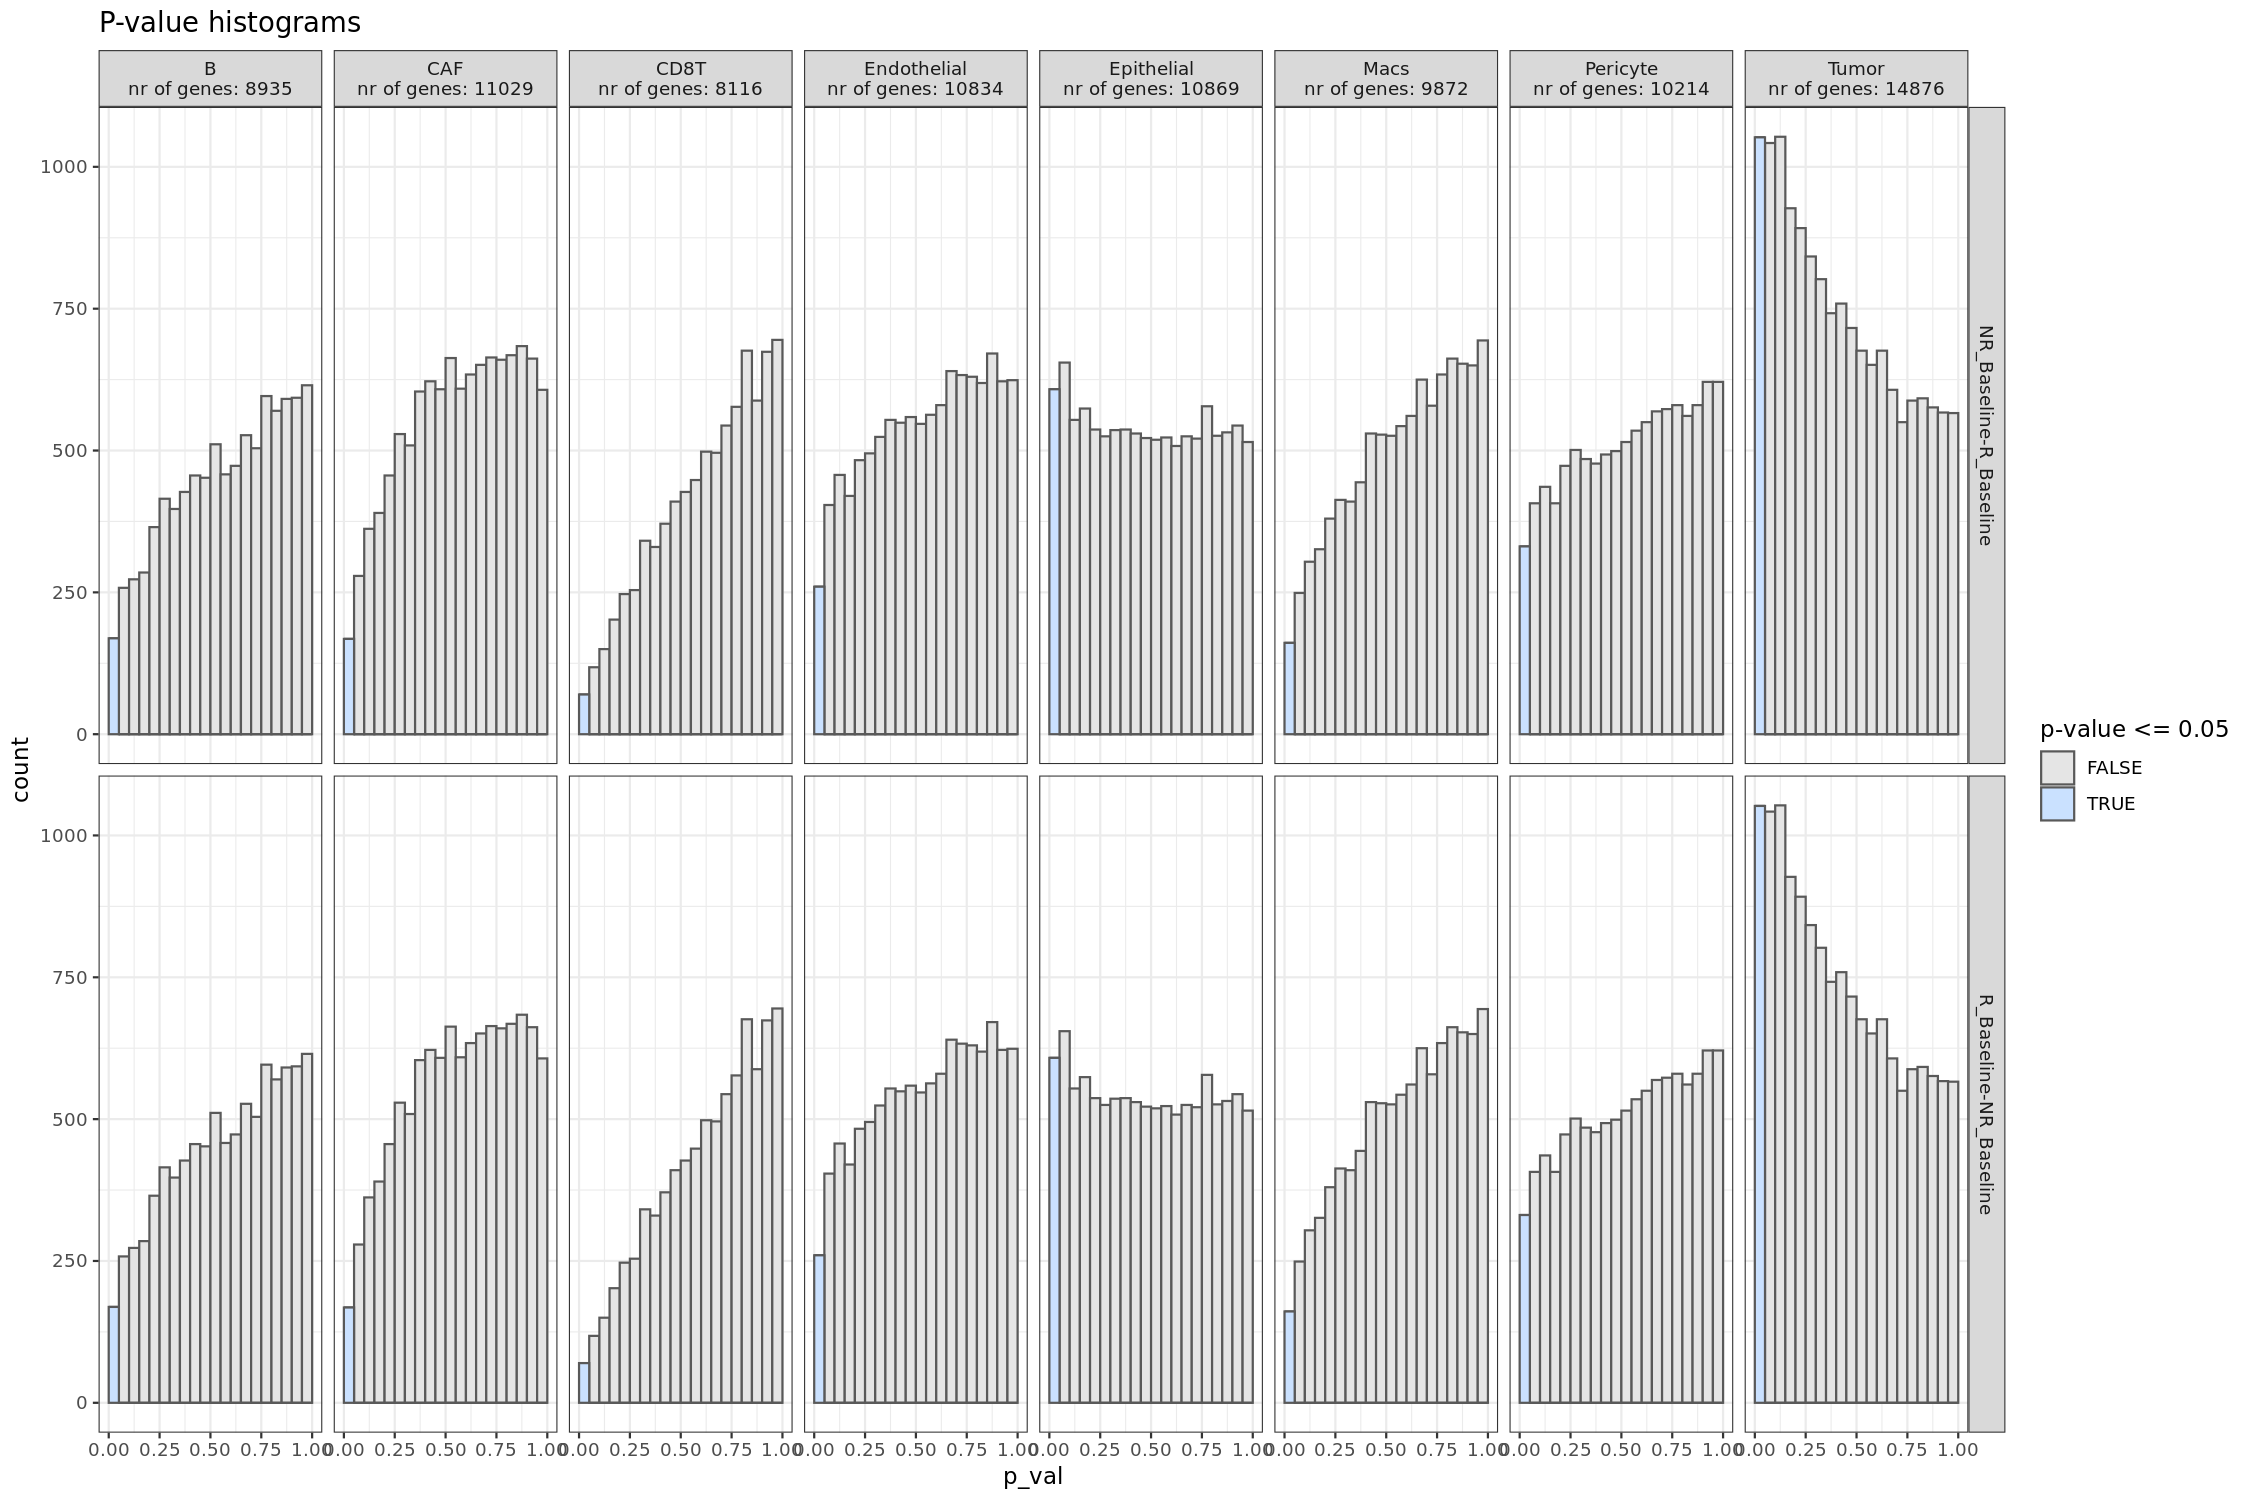

In [29]:
options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 150)
DE_info_group1$hist_pvals

These p-value distributions look irregular, we estimatde empirical p-values.

In [30]:
empirical_pval = TRUE
if(empirical_pval == TRUE){
  DE_info_emp = get_empirical_pvals(DE_info_group1$celltype_de$de_output_tidy)
  celltype_de_group1 = DE_info_emp$de_output_tidy_emp %>% select(-p_val, -p_adj) %>% 
    rename(p_val = p_emp, p_adj = p_adj_emp)
} else {
  celltype_de_group1 = DE_info_group1$celltype_de$de_output_tidy
} 

#### Combine DE information for ligand-senders and receptors-receivers

In [31]:
sender_receiver_de = multinichenetr::combine_sender_receiver_de(
  sender_de = celltype_de_group1,
  receiver_de = celltype_de_group1,
  senders_oi = senders_oi,
  receivers_oi = receivers_oi,
  lr_network = lr_network
)

Ligand activity prediction: use the DE analysis output to predict the activity of ligands in receiver cell types and infer their potential target genes

We will first inspect the geneset_oi-vs-background ratios for the default tresholds:

In [32]:
geneset_assessment = contrast_tbl$contrast %>% 
  lapply(
    process_geneset_data, 
    celltype_de_group1, logFC_threshold, p_val_adj, p_val_threshold
  ) %>% 
  bind_rows() 
geneset_assessment

Joining with `by = join_by(cluster_id)`
Joining with `by = join_by(cluster_id)`
Joining with `by = join_by(cluster_id)`
Joining with `by = join_by(cluster_id)`


cluster_id  n_background n_geneset_up n_geneset_down prop_geneset_up
1  B            8935        199          377            0.022271964    
2  CAF         11029        156          176            0.014144528    
3  CD8T         8116        211          384            0.025998029    
4  Endothelial 10834        166          281            0.015322134    
5  Epithelial  10869        339          188            0.031189622    
6  Macs         9872        255          342            0.025830632    
7  Pericyte    10214        275          359            0.026923830    
8  Tumor       14876        722           61            0.048534552    
9  B            8935        377          199            0.042193621    
10 CAF         11029        176          156            0.015957929    
11 CD8T         8116        384          211            0.047313948    
12 Endothelial 10834        281          166            0.025936865    
13 Epithelial  10869        188          339            0.017296899    
14 Macs         9872        342          255            0.034643436    
15 Pericyte    10214        359          275            0.035147836    
16 Tumor       14876         61          722            0.004100565    
   prop_geneset_down in_range_up in_range_down contrast              
1  0.042193621        TRUE        TRUE         R_Baseline-NR_Baseline
2  0.015957929        TRUE        TRUE         R_Baseline-NR_Baseline
3  0.047313948        TRUE        TRUE         R_Baseline-NR_Baseline
4  0.025936865        TRUE        TRUE         R_Baseline-NR_Baseline
5  0.017296899        TRUE        TRUE         R_Baseline-NR_Baseline
6  0.034643436        TRUE        TRUE         R_Baseline-NR_Baseline
7  0.035147836        TRUE        TRUE         R_Baseline-NR_Baseline
8  0.004100565        TRUE       FALSE         R_Baseline-NR_Baseline
9  0.022271964        TRUE        TRUE         NR_Baseline-R_Baseline
10 0.014144528        TRUE        TRUE         NR_Baseline-R_Baseline
11 0.025998029        TRUE        TRUE         NR_Baseline-R_Baseline
12 0.015322134        TRUE        TRUE         NR_Baseline-R_Baseline
13 0.031189622        TRUE        TRUE         NR_Baseline-R_Baseline
14 0.025830632        TRUE        TRUE         NR_Baseline-R_Baseline
15 0.026923830        TRUE        TRUE         NR_Baseline-R_Baseline
16 0.048534552       FALSE        TRUE         NR_Baseline-R_Baseline
   logFC_threshold p_val_threshold adjusted
1  0.5             0.05            FALSE   
2  0.5             0.05            FALSE   
3  0.5             0.05            FALSE   
4  0.5             0.05            FALSE   
5  0.5             0.05            FALSE   
6  0.5             0.05            FALSE   
7  0.5             0.05            FALSE   
8  0.5             0.05            FALSE   
9  0.5             0.05            FALSE   
10 0.5             0.05            FALSE   
11 0.5             0.05            FALSE   
12 0.5             0.05            FALSE   
13 0.5             0.05            FALSE   
14 0.5             0.05            FALSE   
15 0.5             0.05            FALSE   
16 0.5             0.05            FALSE

We can see here that for all cell type / contrast combinations, all geneset/background ratio's are within the recommended range (in_range_up and in_range_down columns). When these geneset/background ratio's would not be within the recommended ranges, we should interpret ligand activity results for these cell types with more caution, or use different thresholds (for these or all cell types).

In [33]:
ligand_activities_targets_DEgenes = suppressMessages(suppressWarnings(
  get_ligand_activities_targets_DEgenes(
    receiver_de = celltype_de_group1,
    receivers_oi = intersect(receivers_oi, celltype_de_group1$cluster_id %>% unique()),
    ligand_target_matrix = ligand_target_matrix,
    logFC_threshold = logFC_threshold,
    p_val_threshold = p_val_threshold,
    p_val_adj = p_val_adj,
    top_n_target = top_n_target,
    verbose = TRUE, 
    n.cores = n.cores
  )
))

#### Prioritization: rank cell-cell communication patterns through multi-criteria prioritization

In [34]:
sender_receiver_tbl = sender_receiver_de %>% distinct(sender, receiver)

metadata_combined = SummarizedExperiment::colData(sce) %>% tibble::as_tibble()

if(!is.na(batches)){
  grouping_tbl = metadata_combined[,c(sample_id, group_id, batches)] %>% 
    tibble::as_tibble() %>% distinct()
  colnames(grouping_tbl) = c("sample","group",batches)
} else {
  grouping_tbl = metadata_combined[,c(sample_id, group_id)] %>% 
    tibble::as_tibble() %>% distinct()
  colnames(grouping_tbl) = c("sample","group")
}

prioritization_tables = suppressMessages(multinichenetr::generate_prioritization_tables(
    sender_receiver_info = abundance_expression_info$sender_receiver_info,
    sender_receiver_de = sender_receiver_de,
    ligand_activities_targets_DEgenes = ligand_activities_targets_DEgenes,
    contrast_tbl = contrast_tbl,
    sender_receiver_tbl = sender_receiver_tbl,
    grouping_tbl = grouping_tbl,
    scenario = "regular", # all prioritization criteria will be weighted equally
    fraction_cutoff = fraction_cutoff, 
    abundance_data_receiver = abundance_expression_info$abundance_data_receiver,
    abundance_data_sender = abundance_expression_info$abundance_data_sender,
    ligand_activity_down = ligand_activity_down
  ))

Compile the MultiNicheNet output object

In [35]:
multinichenet_output_group1_t2vst1 = list(
    celltype_info = abundance_expression_info$celltype_info,
    celltype_de = celltype_de_group1,
    sender_receiver_info = abundance_expression_info$sender_receiver_info,
    sender_receiver_de =  sender_receiver_de,
    ligand_activities_targets_DEgenes = ligand_activities_targets_DEgenes,
    prioritization_tables = prioritization_tables,
    grouping_tbl = grouping_tbl,
    lr_target_prior_cor = tibble()
  ) 
multinichenet_output_group1_t2vst1 = make_lite_output(multinichenet_output_group1_t2vst1)

## Store the result

#### multinichenetR object

In [36]:
saveRDS(object =multinichenet_output_group1_t2vst1 ,file = file.path(Object_Output_Folder,'multinichenet_NvsNR_Baseline.rds'))

#### prioritization table

In [37]:
prioritized_tbl_oi_all = get_top_n_lr_pairs(prioritization_tables, 3000, rank_per_group =T,
                                            senders_oi = c('CD8T','Macs','Tumor'),
                                            receivers_oi= c('CD8T','Macs','Tumor')
                                           )
write.table(prioritized_tbl_oi_all,'../data/table/multinichenetR/multinichenetr_NR_vs_R_Baseline_Top3000_per_group.tsv',
            row.names =F,quote = F,sep='\t')
write.table(prioritization_tables$sample_prioritization_tbl,
            '../data/table/multinichenetR/multinichenetr_NR_vs_R_Baseline_sample_prioritization_tbl.tsv',row.names =F,quote = F,sep='\t')
write.table(prioritization_tables$group_prioritization_tbl,
            '../data/table/multinichenetR/multinichenetr_NR_vs_R_Baseline_group_prioritization_tbl.tsv',row.names =F,quote = F,sep='\t')

### Visualization

Joining with `by = join_by(id, sender, receiver, ligand, receptor, group)`
Joining with `by = join_by(sender)`
Joining with `by = join_by(receiver)`
Joining with `by = join_by(sender)`
Joining with `by = join_by(receiver)`


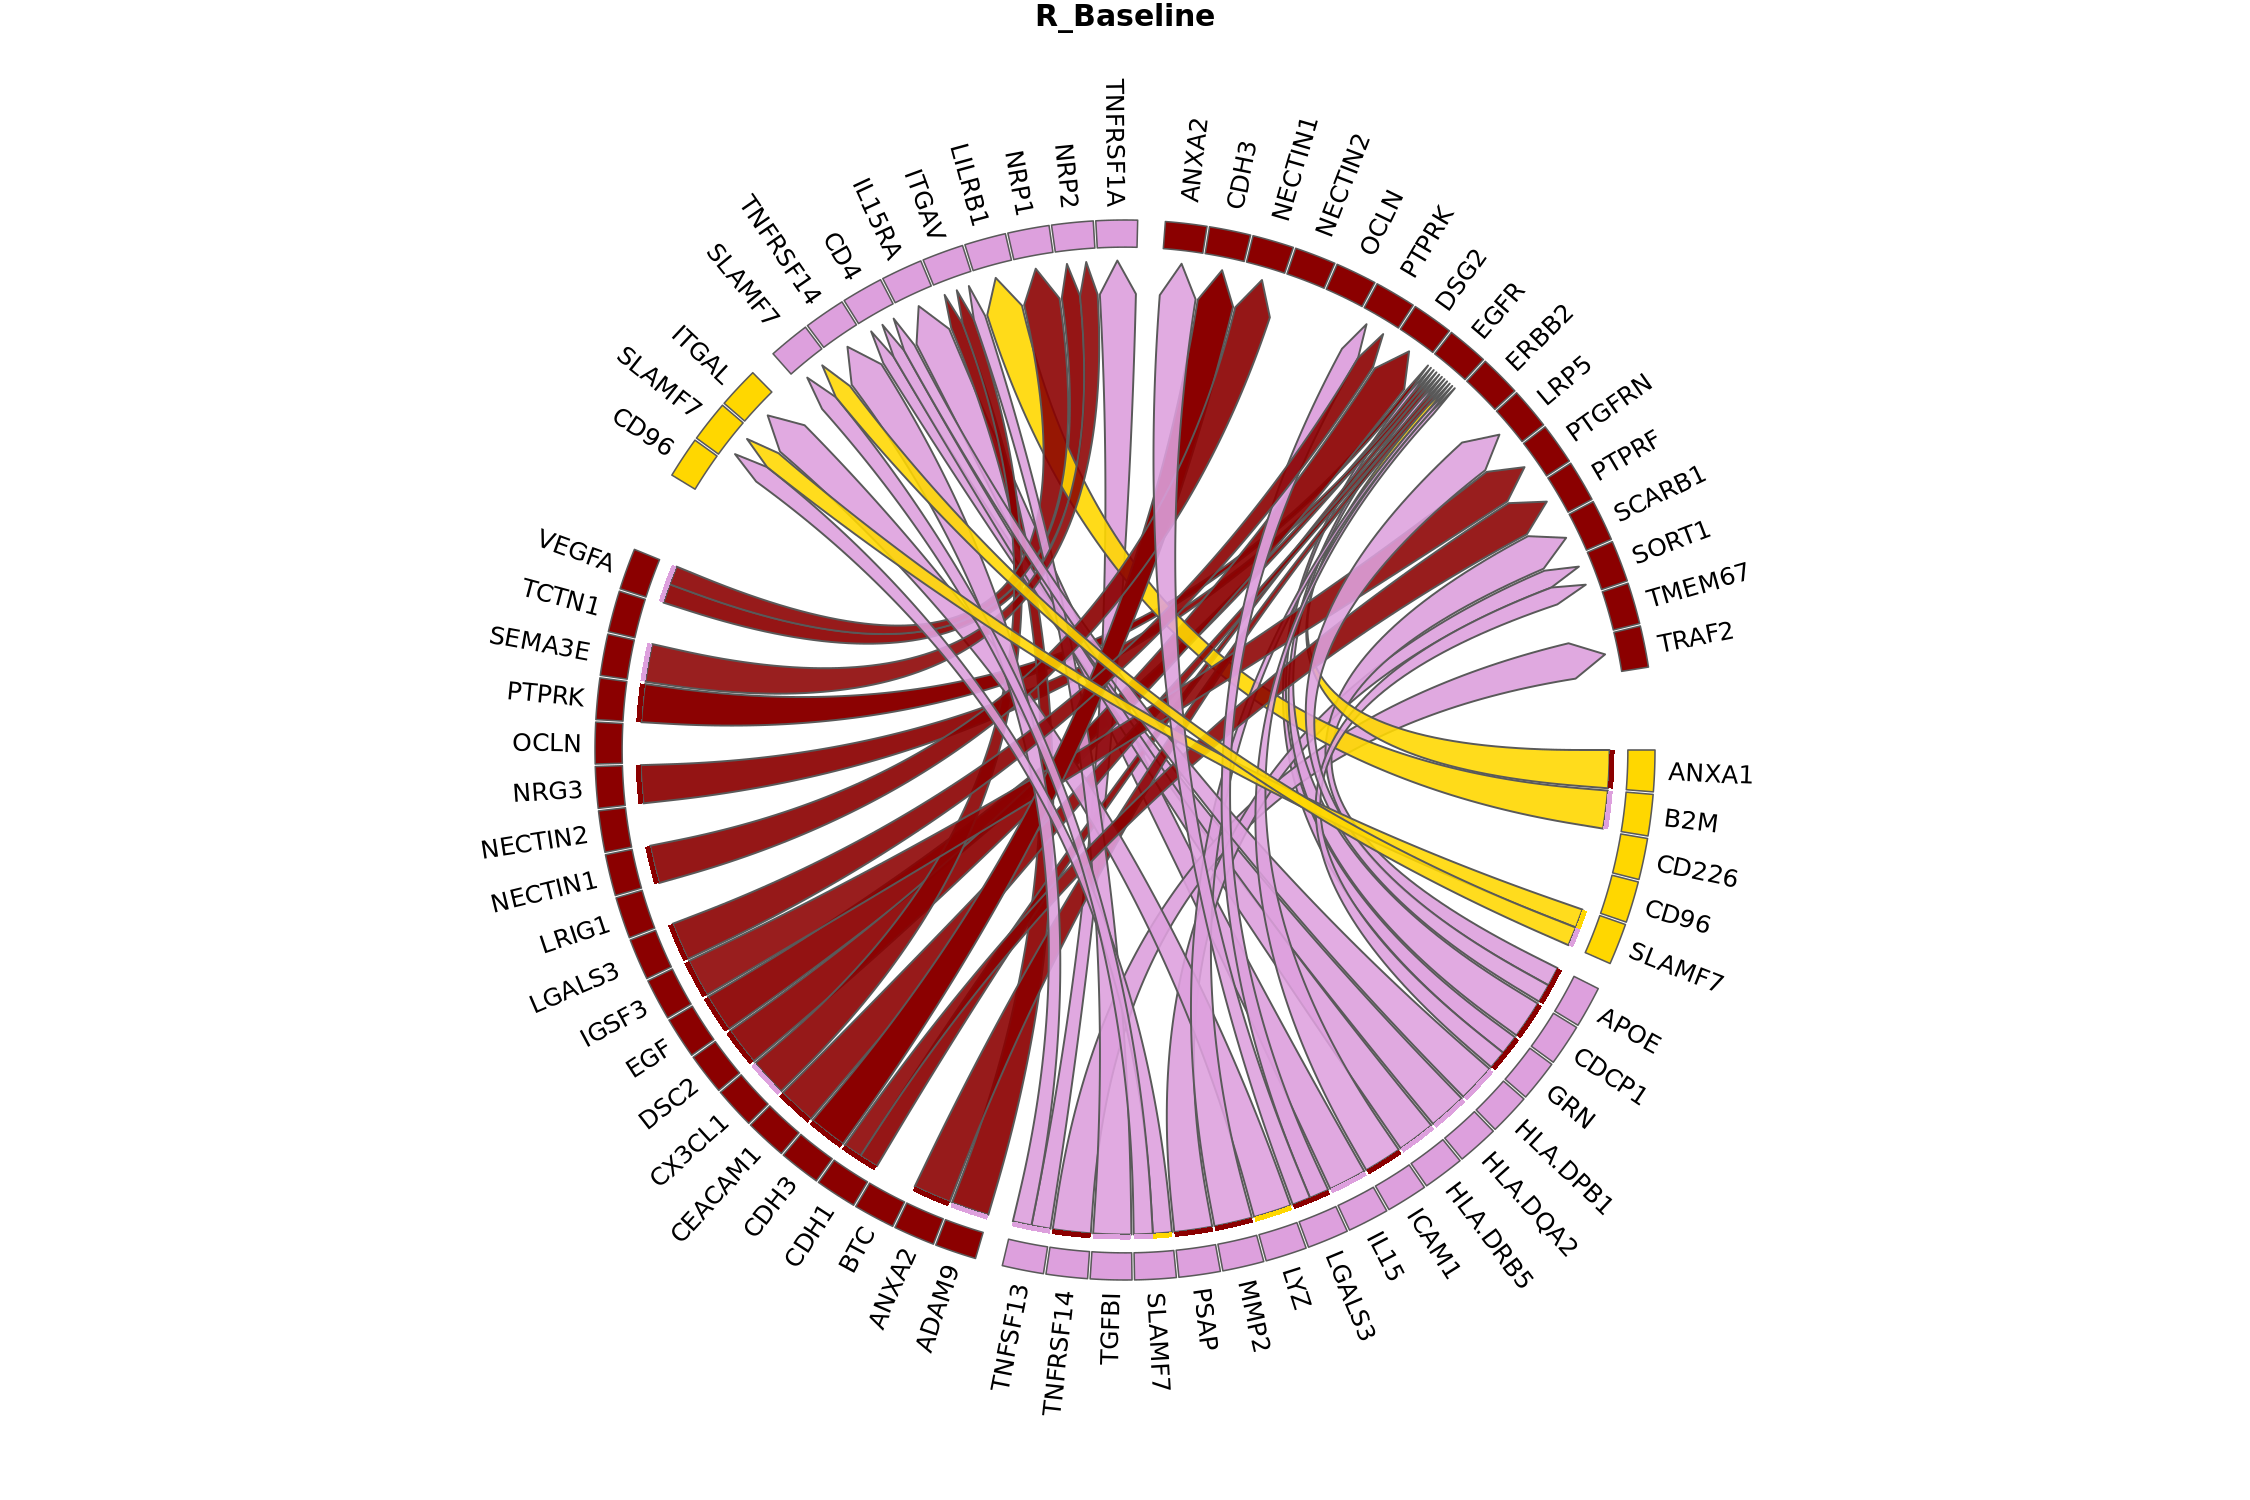

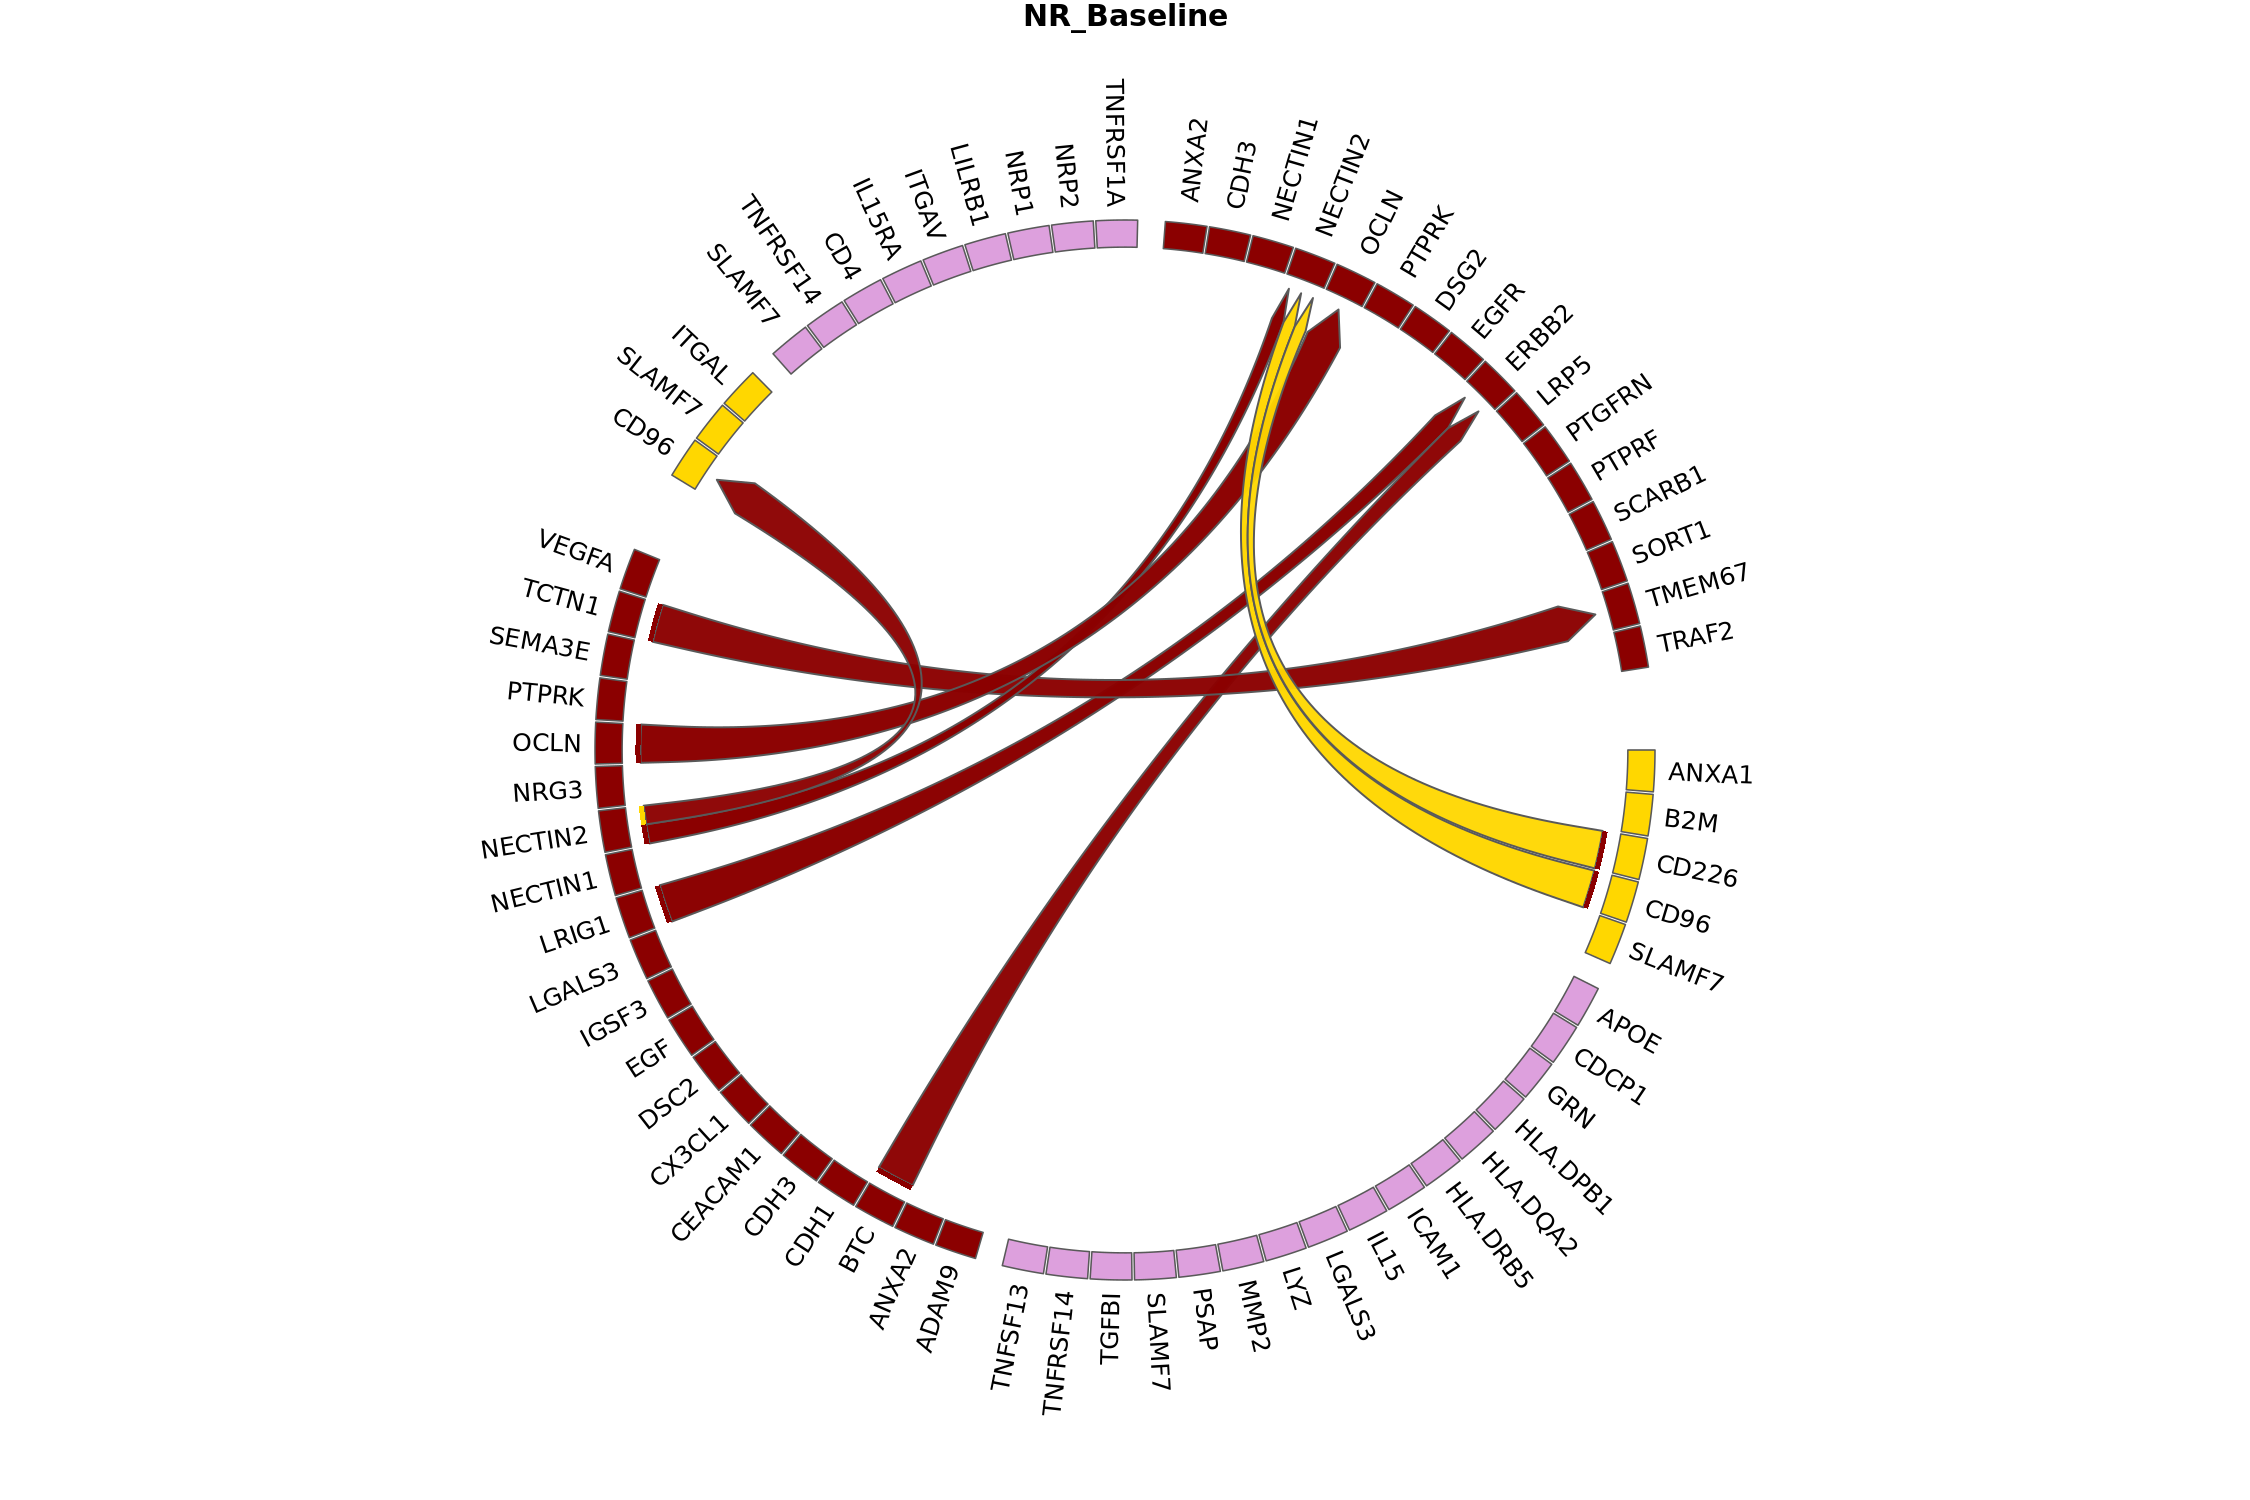

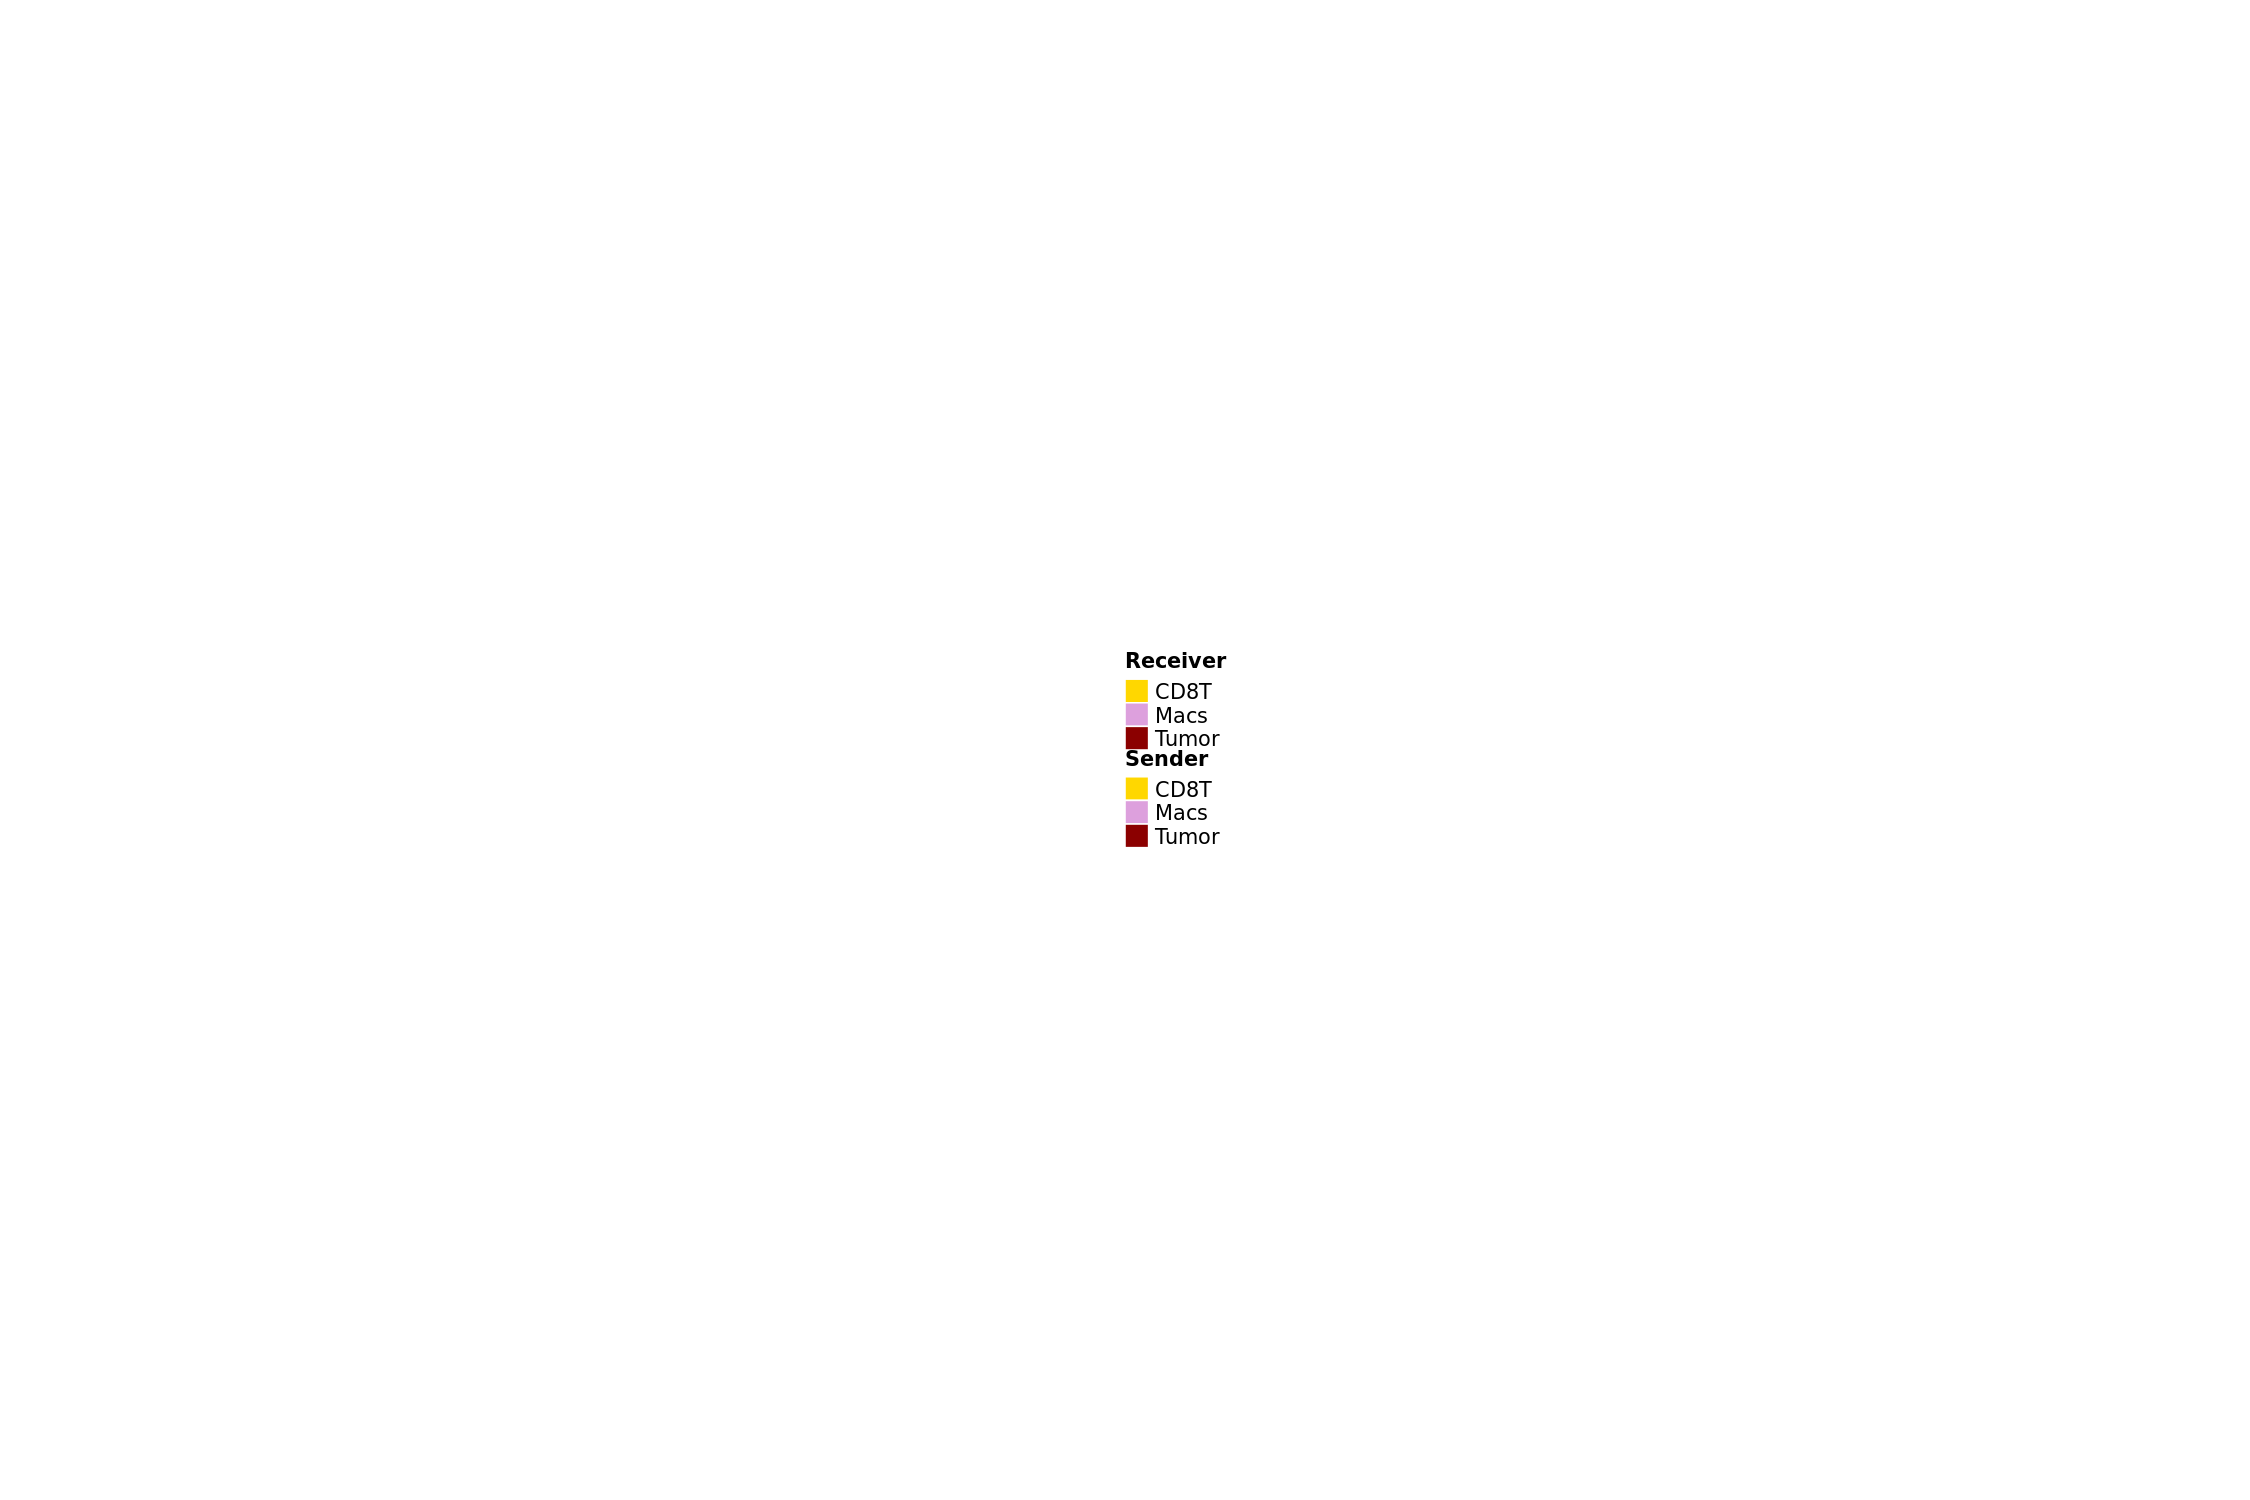

In [38]:
prioritized_tbl_oi_all = get_top_n_lr_pairs(
  multinichenet_output_group1_t2vst1$prioritization_tables, 
  top_n = 50, 
  rank_per_group = FALSE,
    senders_oi = c('CD8T','Macs','Tumor'),
    receivers_oi= c('CD8T','Macs','Tumor')
  )

prioritized_tbl_oi = 
  multinichenet_output_group1_t2vst1$prioritization_tables$group_prioritization_tbl %>%
  filter(id %in% prioritized_tbl_oi_all$id) %>%
  distinct(id, sender, receiver, ligand, receptor, group) %>% 
  left_join(prioritized_tbl_oi_all)
prioritized_tbl_oi$prioritization_score[is.na(prioritized_tbl_oi$prioritization_score)] = 0

senders_receivers = union(prioritized_tbl_oi$sender %>% unique(), prioritized_tbl_oi$receiver %>% unique()) %>% sort()

colors_sender = c()
colors_name = c()
for( celltype in names(COLOR_PAlETTE$Celltype)){
    if(celltype %in% senders_receivers){
        colors_sender  = c(colors_sender ,COLOR_PAlETTE$Celltype[[celltype]])
        colors_name = c(colors_name,celltype)
        }
}
colors_sender = colors_sender %>% magrittr::set_names(colors_name)
colors_receiver = colors_sender

circos_list = make_circos_group_comparison(prioritized_tbl_oi, colors_sender, colors_receiver)


# Compare R vs NR in W7D1

In [39]:
group_id = "BestResponse_Timepoint"
compared_groups =  c("R_W7D1","NR_W7D1")

In [40]:
contrast = c(paste(compared_groups,collapse ='-'),
  paste(c(compared_groups[2],compared_groups[1]),collapse ='-')
 )
contrasts_oi = c(paste0("'",paste(contrast,collapse ="','"),"'"))
contrast_tbl = tibble(contrast =contrast,
                      group = compared_groups) 
contrasts_oi

[1] "'R_W7D1-NR_W7D1','NR_W7D1-R_W7D1'"

## Subset cells that are in senders and receiver cell type

In [41]:
sce = sce_all[, colData(sce_all)[,celltype_id] %in% c(senders_oi, receivers_oi)]
sce = sce[, colData(sce)[,group_id] %in% compared_groups]
sce

class: SingleCellExperiment 
dim: 36601 45973 
metadata(0):
assays(1): counts
rownames(36601): MIR1302.2HG FAM138A ... AC007325.4 AC007325.2
rowData names(0):
colnames(45973): GCTAGCCAGGACAACA-1_CCG1112_01_T3_A_CCG1112_MO_Batch3
  TCAGTGAGTGCTCACC-1_CCG1112_01_T3_A_CCG1112_MO_Batch3 ...
  GGCTGGTTCGAATGCT-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1
  TCACAAGGTAATTGGA-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1
colData names(33): n_genes_by_counts log1p_n_genes_by_counts ...
  Patient Treatment_Arm
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

## Perform MultiNicheNet’s cell-cell communication analysis

In [42]:
n.cores = min(cores_system, union(senders_oi, receivers_oi) %>% length()) # use one core per receiver cell type

#### Celltype-filtering

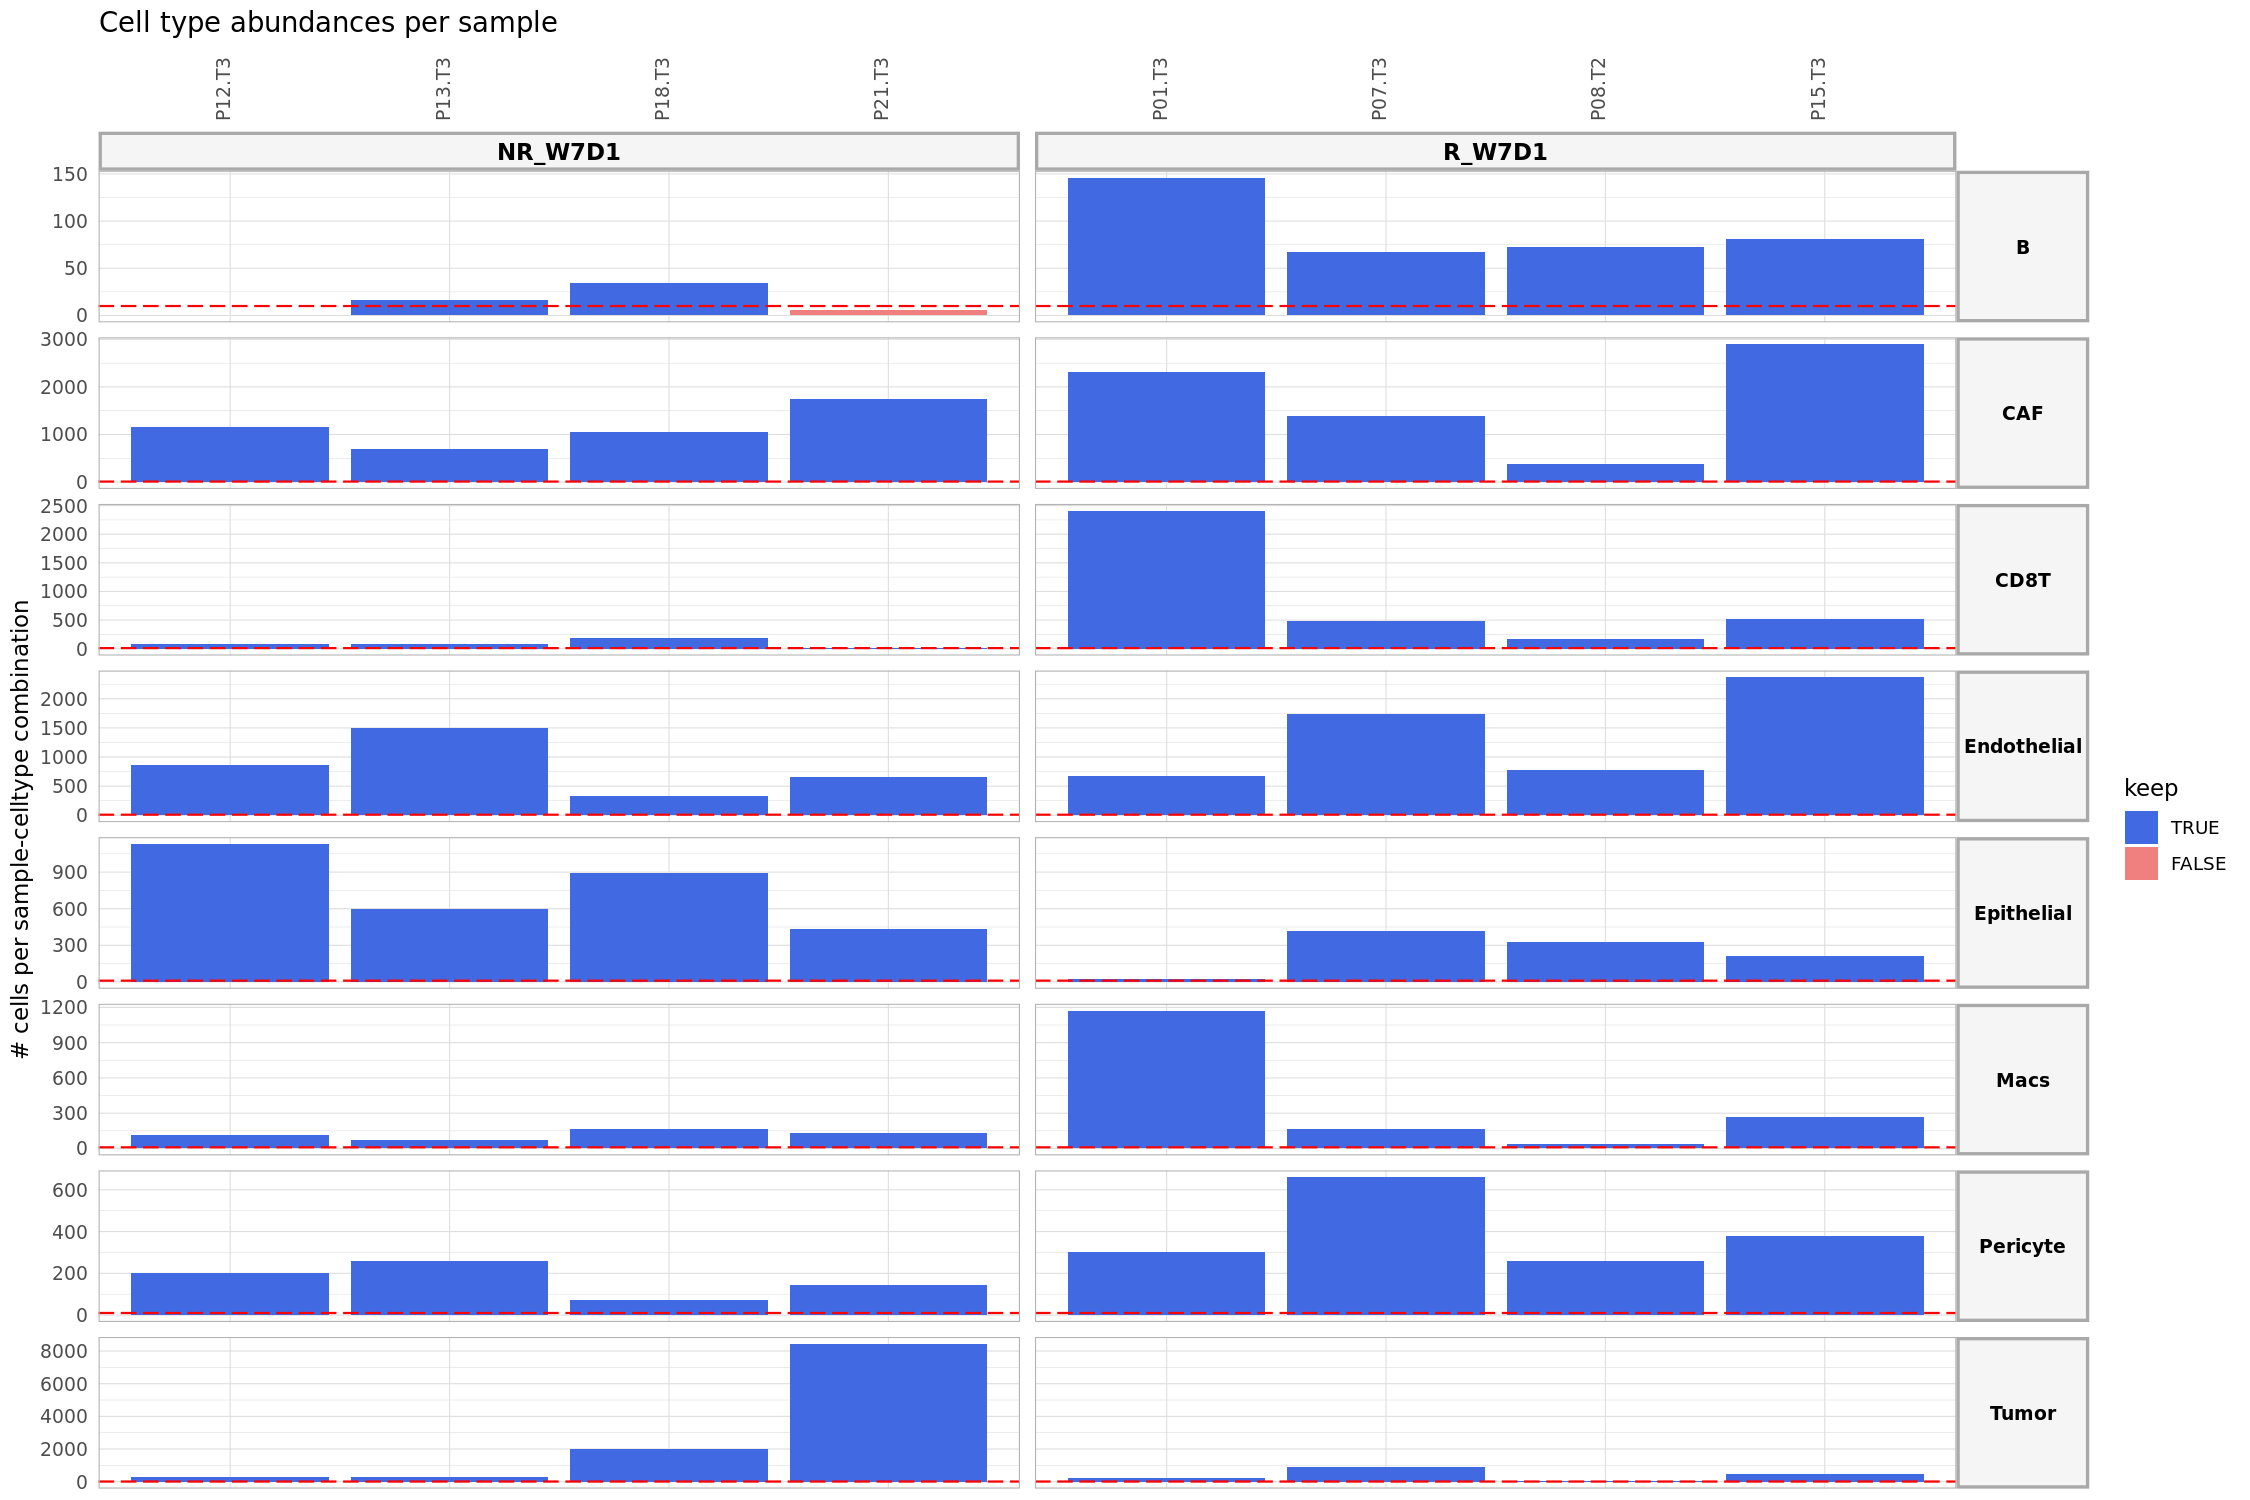

In [43]:
abundance_info = get_abundance_info(
  sce = sce, 
  sample_id = sample_id, group_id = group_id, celltype_id = celltype_id, 
  min_cells = min_cells, 
  senders_oi = senders_oi, receivers_oi = receivers_oi, 
  batches = batches
  )
abundance_info$abund_plot_sample

#### Gene filtering

In [44]:
frq_list = get_frac_exprs(
  sce = sce, 
  sample_id = sample_id, celltype_id =  celltype_id, group_id = group_id, 
  batches = batches, 
  min_cells = min_cells, 
  fraction_cutoff = fraction_cutoff, min_sample_prop = min_sample_prop)

Joining with `by = join_by(sample, group)`


[1] "Samples are considered if they have more than 10 cells of the cell type of interest"


Joining with `by = join_by(sample, celltype)`


[1] "Genes with non-zero counts in at least 5% of cells of a cell type of interest in a particular sample will be considered as expressed in that sample."
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: B"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: CAF"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: CD8T"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: Endothelial"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: Epithelial"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: Macs"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: Pericyte"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: Tumor"


Joining with `by = join_by(sample)`
Joining with `by = join_by(celltype)`
Joining with `by = join_by(sample, celltype, group)`


[1] "8360 genes are considered as expressed in the cell type: B"
[1] "9879 genes are considered as expressed in the cell type: CAF"
[1] "8143 genes are considered as expressed in the cell type: CD8T"
[1] "10099 genes are considered as expressed in the cell type: Endothelial"
[1] "11355 genes are considered as expressed in the cell type: Epithelial"
[1] "8872 genes are considered as expressed in the cell type: Macs"
[1] "9094 genes are considered as expressed in the cell type: Pericyte"
[1] "13165 genes are considered as expressed in the cell type: Tumor"


now only keep genes that are expressed by at least one cell type:

In [45]:
genes_oi = frq_list$expressed_df %>% 
  filter(expressed == TRUE) %>% pull(gene) %>% unique() 
sce = sce[genes_oi, ]

#### Pseudobulk expression calculation
determine and normalize per-sample pseudobulk expression levels for each expressed gene in each present cell type

In [46]:
abundance_expression_info = process_abundance_expression_info(
  sce = sce, 
  sample_id = sample_id, group_id = group_id, celltype_id = celltype_id, 
  min_cells = min_cells, 
  senders_oi = senders_oi, receivers_oi = receivers_oi, 
  lr_network = lr_network, 
  batches = batches, 
  frq_list = frq_list, 
  abundance_info = abundance_info)

  |======================================================================| 100%



Joining with `by = join_by(sender, receiver, ligand, receptor)`
Joining with `by = join_by(sender, receiver, ligand, receptor)`
Joining with `by = join_by(sender, receiver, ligand, receptor)`


#### Differential expression (DE) analysis
determine which genes are differentially expressed

In [47]:
DE_info_group1 = get_DE_info(
  sce = sce, 
  sample_id = sample_id, group_id = group_id, celltype_id = celltype_id, 
  batches = batches, covariates = covariates, 
  contrasts_oi = contrasts_oi, 
  min_cells = min_cells, 
  expressed_df = frq_list$expressed_df)

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

[1] "DE analysis is done:"
[1] "included cell types are:"
[1] "CD8T"        "Tumor"       "CAF"         "Macs"        "Endothelial"
[6] "Epithelial"  "Pericyte"    "B"          


Evaluate the distributions of p-values:

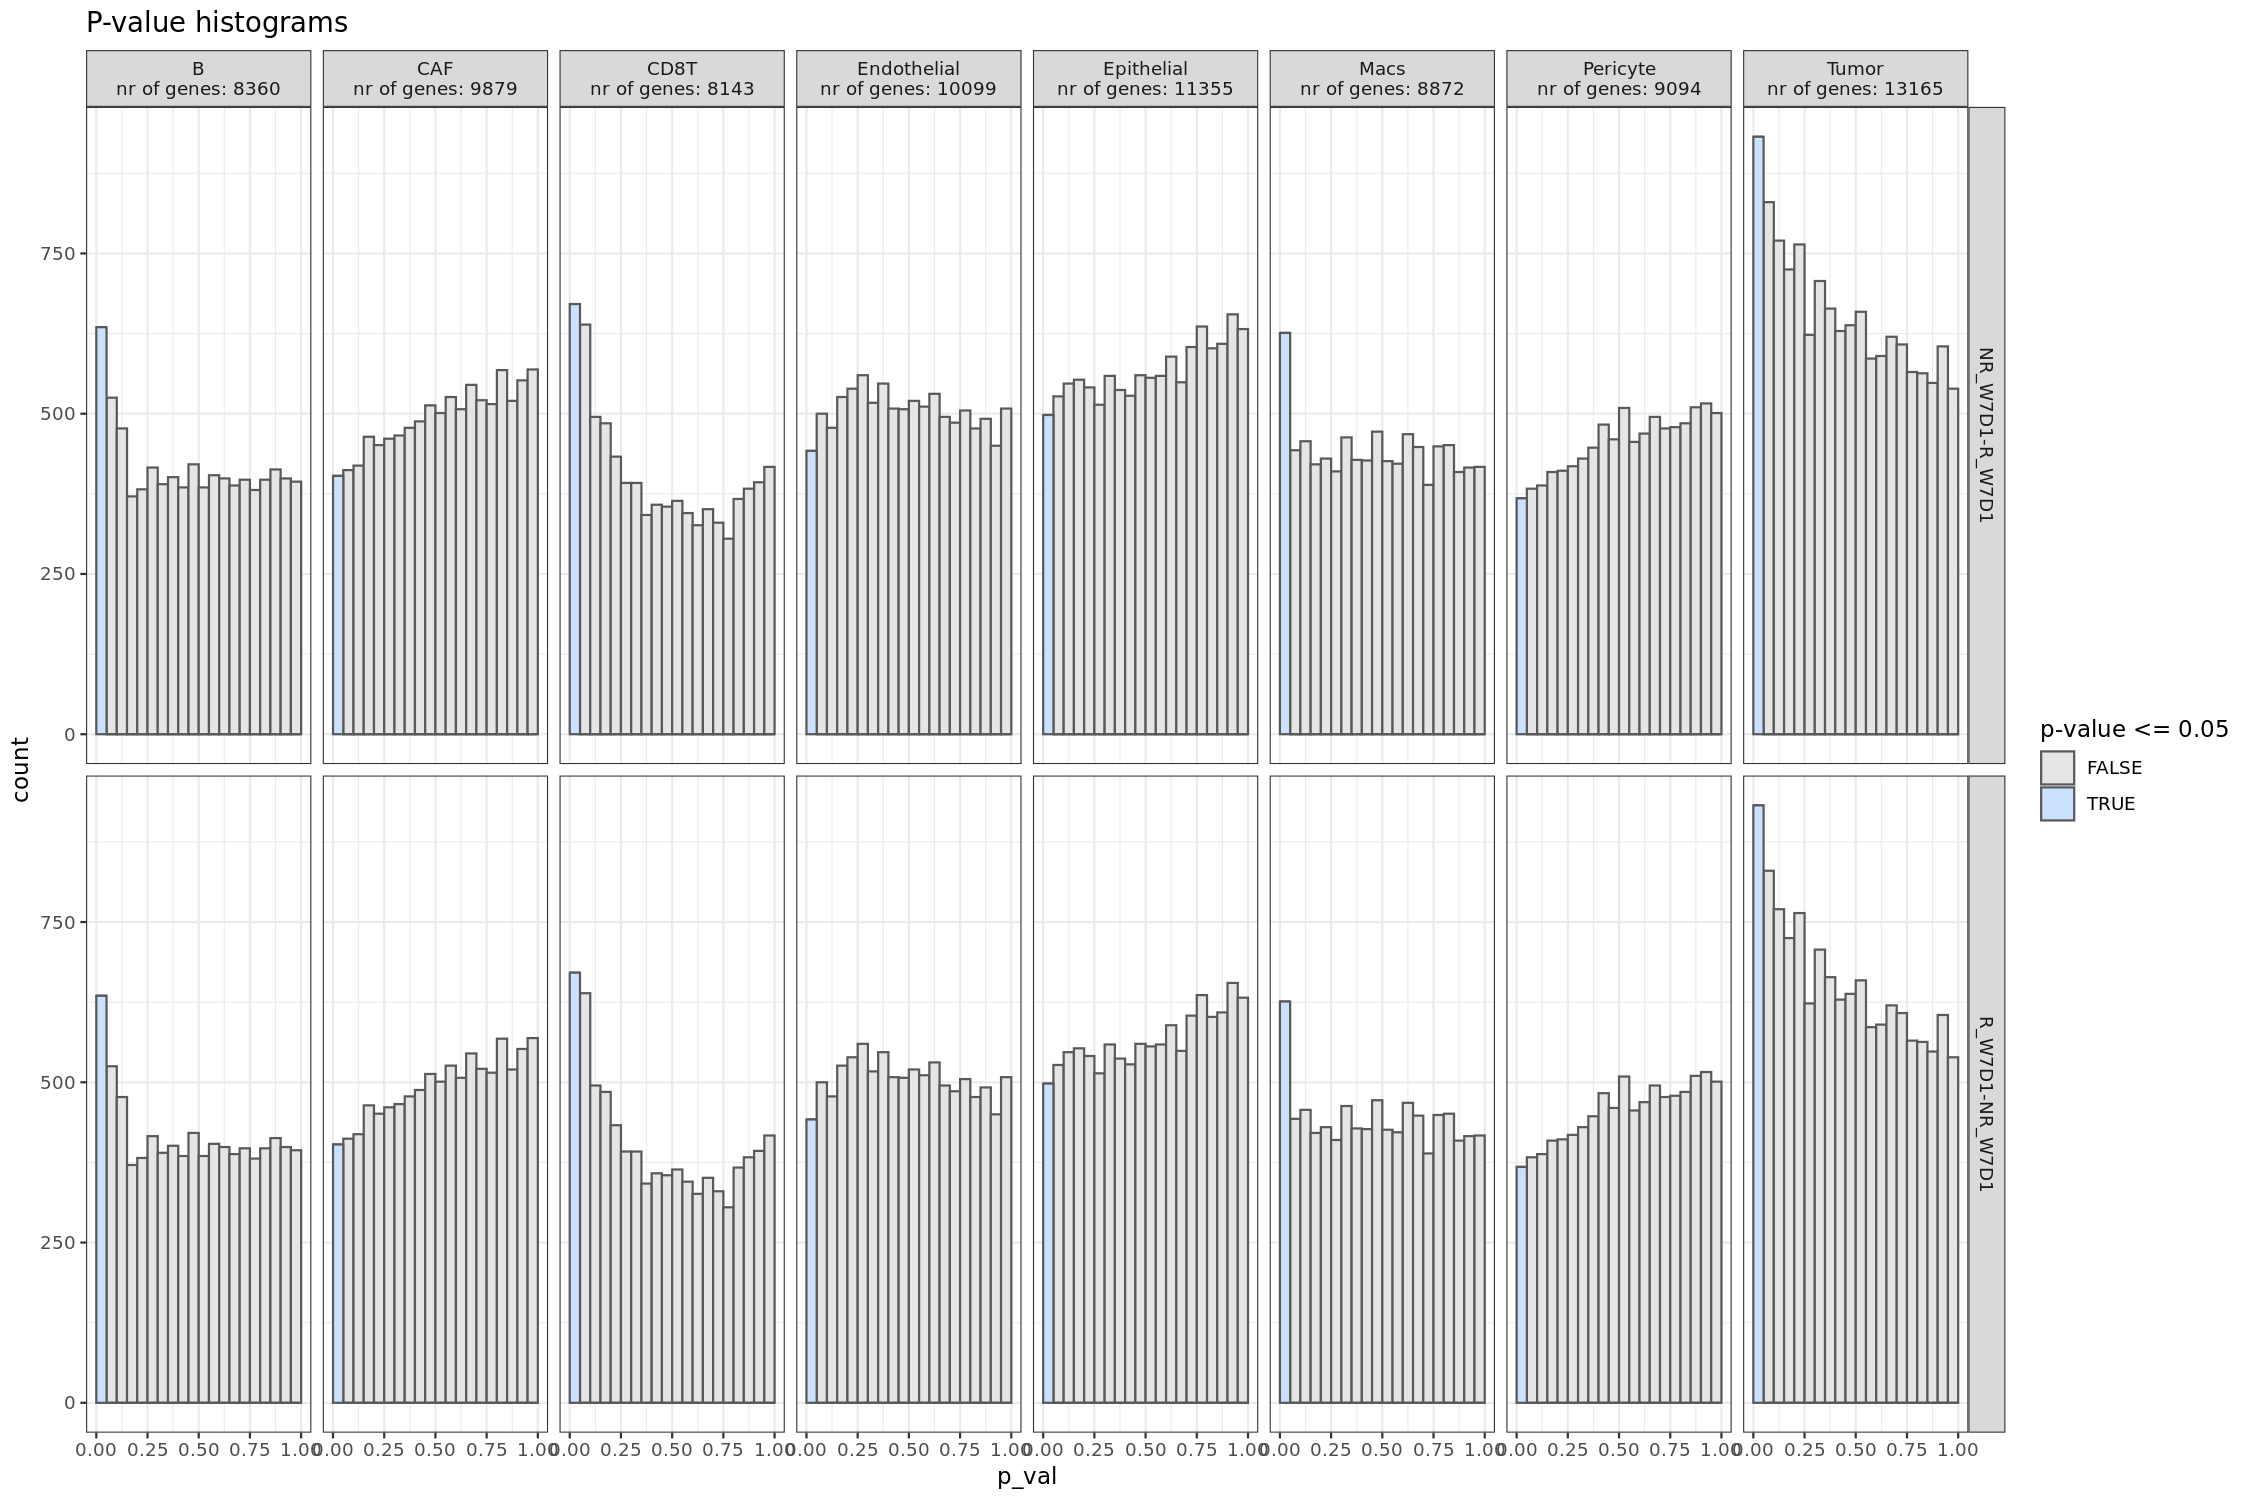

In [48]:
options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 150)
DE_info_group1$hist_pvals

These p-value distributions look fine, with a uniform distribution with a peak at p-value <= 0.05. 

In [49]:
empirical_pval = FALSE
if(empirical_pval == TRUE){
  DE_info_emp = get_empirical_pvals(DE_info_group1$celltype_de$de_output_tidy)
  celltype_de_group1 = DE_info_emp$de_output_tidy_emp %>% select(-p_val, -p_adj) %>% 
    rename(p_val = p_emp, p_adj = p_adj_emp)
} else {
  celltype_de_group1 = DE_info_group1$celltype_de$de_output_tidy
} 

#### Combine DE information for ligand-senders and receptors-receivers

In [50]:
sender_receiver_de = multinichenetr::combine_sender_receiver_de(
  sender_de = celltype_de_group1,
  receiver_de = celltype_de_group1,
  senders_oi = senders_oi,
  receivers_oi = receivers_oi,
  lr_network = lr_network
)

Ligand activity prediction: use the DE analysis output to predict the activity of ligands in receiver cell types and infer their potential target genes

We will first inspect the geneset_oi-vs-background ratios for the default tresholds:

In [51]:
geneset_assessment = contrast_tbl$contrast %>% 
  lapply(
    process_geneset_data, 
    celltype_de_group1, logFC_threshold, p_val_adj, p_val_threshold
  ) %>% 
  bind_rows() 
geneset_assessment

Joining with `by = join_by(cluster_id)`
Joining with `by = join_by(cluster_id)`
Joining with `by = join_by(cluster_id)`
Joining with `by = join_by(cluster_id)`


cluster_id  n_background n_geneset_up n_geneset_down prop_geneset_up
1  B            8360        390          245            0.04665072     
2  CAF          9879        237          166            0.02399028     
3  CD8T         8143        382          289            0.04691146     
4  Endothelial 10099        311          131            0.03079513     
5  Epithelial  11355        246          252            0.02166446     
6  Macs         8872        417          209            0.04700180     
7  Pericyte     9094        228          140            0.02507148     
8  Tumor       13165        464          468            0.03524497     
9  B            8360        245          390            0.02930622     
10 CAF          9879        166          237            0.01680332     
11 CD8T         8143        289          382            0.03549061     
12 Endothelial 10099        131          311            0.01297158     
13 Epithelial  11355        252          246            0.02219287     
14 Macs         8872        209          417            0.02355726     
15 Pericyte     9094        140          228            0.01539477     
16 Tumor       13165        468          464            0.03554880     
   prop_geneset_down in_range_up in_range_down contrast       logFC_threshold
1  0.02930622        TRUE        TRUE          R_W7D1-NR_W7D1 0.5            
2  0.01680332        TRUE        TRUE          R_W7D1-NR_W7D1 0.5            
3  0.03549061        TRUE        TRUE          R_W7D1-NR_W7D1 0.5            
4  0.01297158        TRUE        TRUE          R_W7D1-NR_W7D1 0.5            
5  0.02219287        TRUE        TRUE          R_W7D1-NR_W7D1 0.5            
6  0.02355726        TRUE        TRUE          R_W7D1-NR_W7D1 0.5            
7  0.01539477        TRUE        TRUE          R_W7D1-NR_W7D1 0.5            
8  0.03554880        TRUE        TRUE          R_W7D1-NR_W7D1 0.5            
9  0.04665072        TRUE        TRUE          NR_W7D1-R_W7D1 0.5            
10 0.02399028        TRUE        TRUE          NR_W7D1-R_W7D1 0.5            
11 0.04691146        TRUE        TRUE          NR_W7D1-R_W7D1 0.5            
12 0.03079513        TRUE        TRUE          NR_W7D1-R_W7D1 0.5            
13 0.02166446        TRUE        TRUE          NR_W7D1-R_W7D1 0.5            
14 0.04700180        TRUE        TRUE          NR_W7D1-R_W7D1 0.5            
15 0.02507148        TRUE        TRUE          NR_W7D1-R_W7D1 0.5            
16 0.03524497        TRUE        TRUE          NR_W7D1-R_W7D1 0.5            
   p_val_threshold adjusted
1  0.05            FALSE   
2  0.05            FALSE   
3  0.05            FALSE   
4  0.05            FALSE   
5  0.05            FALSE   
6  0.05            FALSE   
7  0.05            FALSE   
8  0.05            FALSE   
9  0.05            FALSE   
10 0.05            FALSE   
11 0.05            FALSE   
12 0.05            FALSE   
13 0.05            FALSE   
14 0.05            FALSE   
15 0.05            FALSE   
16 0.05            FALSE

We can see here that for all cell type / contrast combinations, all geneset/background ratio's are within the recommended range (in_range_up and in_range_down columns). When these geneset/background ratio's would not be within the recommended ranges, we should interpret ligand activity results for these cell types with more caution, or use different thresholds (for these or all cell types).

In [52]:
ligand_activities_targets_DEgenes = suppressMessages(suppressWarnings(
  get_ligand_activities_targets_DEgenes(
    receiver_de = celltype_de_group1,
    receivers_oi = intersect(receivers_oi, celltype_de_group1$cluster_id %>% unique()),
    ligand_target_matrix = ligand_target_matrix,
    logFC_threshold = logFC_threshold,
    p_val_threshold = p_val_threshold,
    p_val_adj = p_val_adj,
    top_n_target = top_n_target,
    verbose = TRUE, 
    n.cores = n.cores
  )
))

#### Prioritization: rank cell-cell communication patterns through multi-criteria prioritization

In [53]:
sender_receiver_tbl = sender_receiver_de %>% distinct(sender, receiver)

metadata_combined = SummarizedExperiment::colData(sce) %>% tibble::as_tibble()

if(!is.na(batches)){
  grouping_tbl = metadata_combined[,c(sample_id, group_id, batches)] %>% 
    tibble::as_tibble() %>% distinct()
  colnames(grouping_tbl) = c("sample","group",batches)
} else {
  grouping_tbl = metadata_combined[,c(sample_id, group_id)] %>% 
    tibble::as_tibble() %>% distinct()
  colnames(grouping_tbl) = c("sample","group")
}

prioritization_tables = suppressMessages(multinichenetr::generate_prioritization_tables(
    sender_receiver_info = abundance_expression_info$sender_receiver_info,
    sender_receiver_de = sender_receiver_de,
    ligand_activities_targets_DEgenes = ligand_activities_targets_DEgenes,
    contrast_tbl = contrast_tbl,
    sender_receiver_tbl = sender_receiver_tbl,
    grouping_tbl = grouping_tbl,
    scenario = "regular", # all prioritization criteria will be weighted equally
    fraction_cutoff = fraction_cutoff, 
    abundance_data_receiver = abundance_expression_info$abundance_data_receiver,
    abundance_data_sender = abundance_expression_info$abundance_data_sender,
    ligand_activity_down = ligand_activity_down
  ))

Compile the MultiNicheNet output object

In [54]:
multinichenet_output_group1_t2vst1 = list(
    celltype_info = abundance_expression_info$celltype_info,
    celltype_de = celltype_de_group1,
    sender_receiver_info = abundance_expression_info$sender_receiver_info,
    sender_receiver_de =  sender_receiver_de,
    ligand_activities_targets_DEgenes = ligand_activities_targets_DEgenes,
    prioritization_tables = prioritization_tables,
    grouping_tbl = grouping_tbl,
    lr_target_prior_cor = tibble()
  ) 
multinichenet_output_group1_t2vst1 = make_lite_output(multinichenet_output_group1_t2vst1)

## Store the result
#### multinichenetR object

In [55]:
saveRDS(object =multinichenet_output_group1_t2vst1 ,file = file.path(Object_Output_Folder,'multinichenet_NvsNR_W7D1.rds'))

#### prioritization table

In [56]:
prioritized_tbl_oi_all = get_top_n_lr_pairs(prioritization_tables, 3000, rank_per_group =T,
                                            senders_oi = c('CD8T','Macs','Tumor'),
                                            receivers_oi= c('CD8T','Macs','Tumor')
                                           )
write.table(prioritized_tbl_oi_all,'../data/table/multinichenetR/multinichenetr_NR_vs_R_W7D1_Top3000_per_group.tsv',
            row.names =F,quote = F,sep='\t')
write.table(prioritization_tables$sample_prioritization_tbl,
            '../data/table/multinichenetR/multinichenetr_NR_vs_R_W7D1_sample_prioritization_tbl.tsv',row.names =F,quote = F,sep='\t')
write.table(prioritization_tables$group_prioritization_tbl,
            '../data/table/multinichenetR/multinichenetr_NR_vs_R_W7D1_group_prioritization_tbl.tsv',row.names =F,quote = F,sep='\t')

### Visualization

Joining with `by = join_by(id, sender, receiver, ligand, receptor, group)`
Joining with `by = join_by(sender)`
Joining with `by = join_by(receiver)`
Joining with `by = join_by(sender)`
Joining with `by = join_by(receiver)`


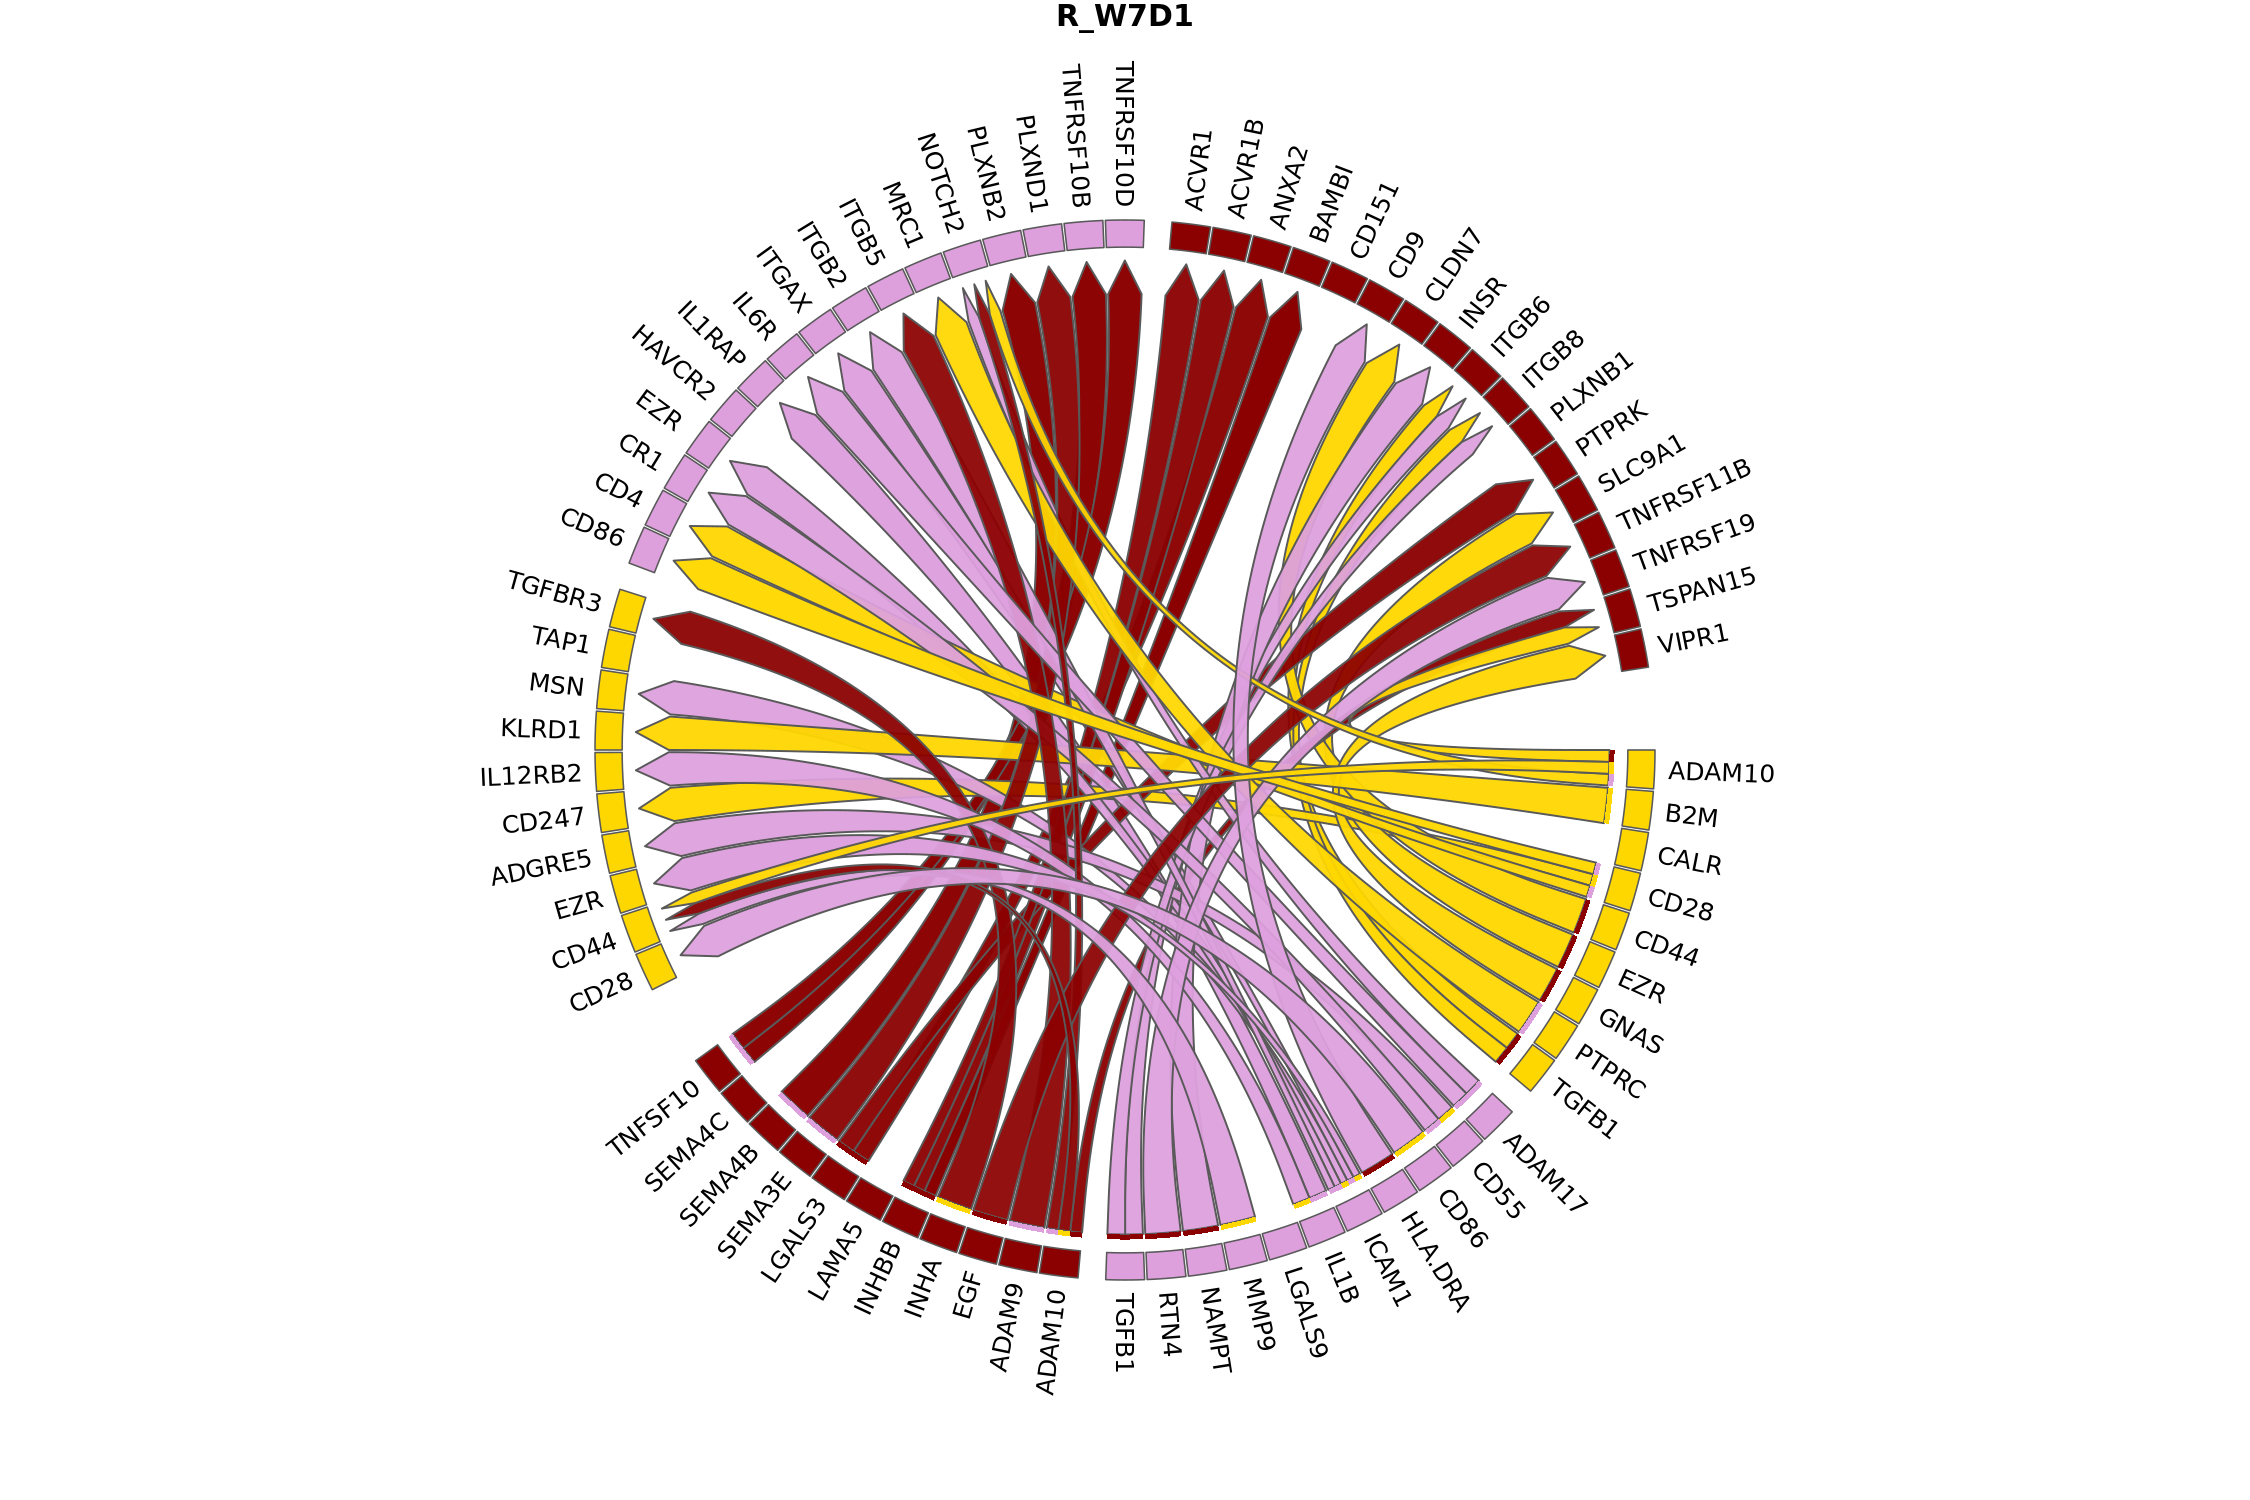

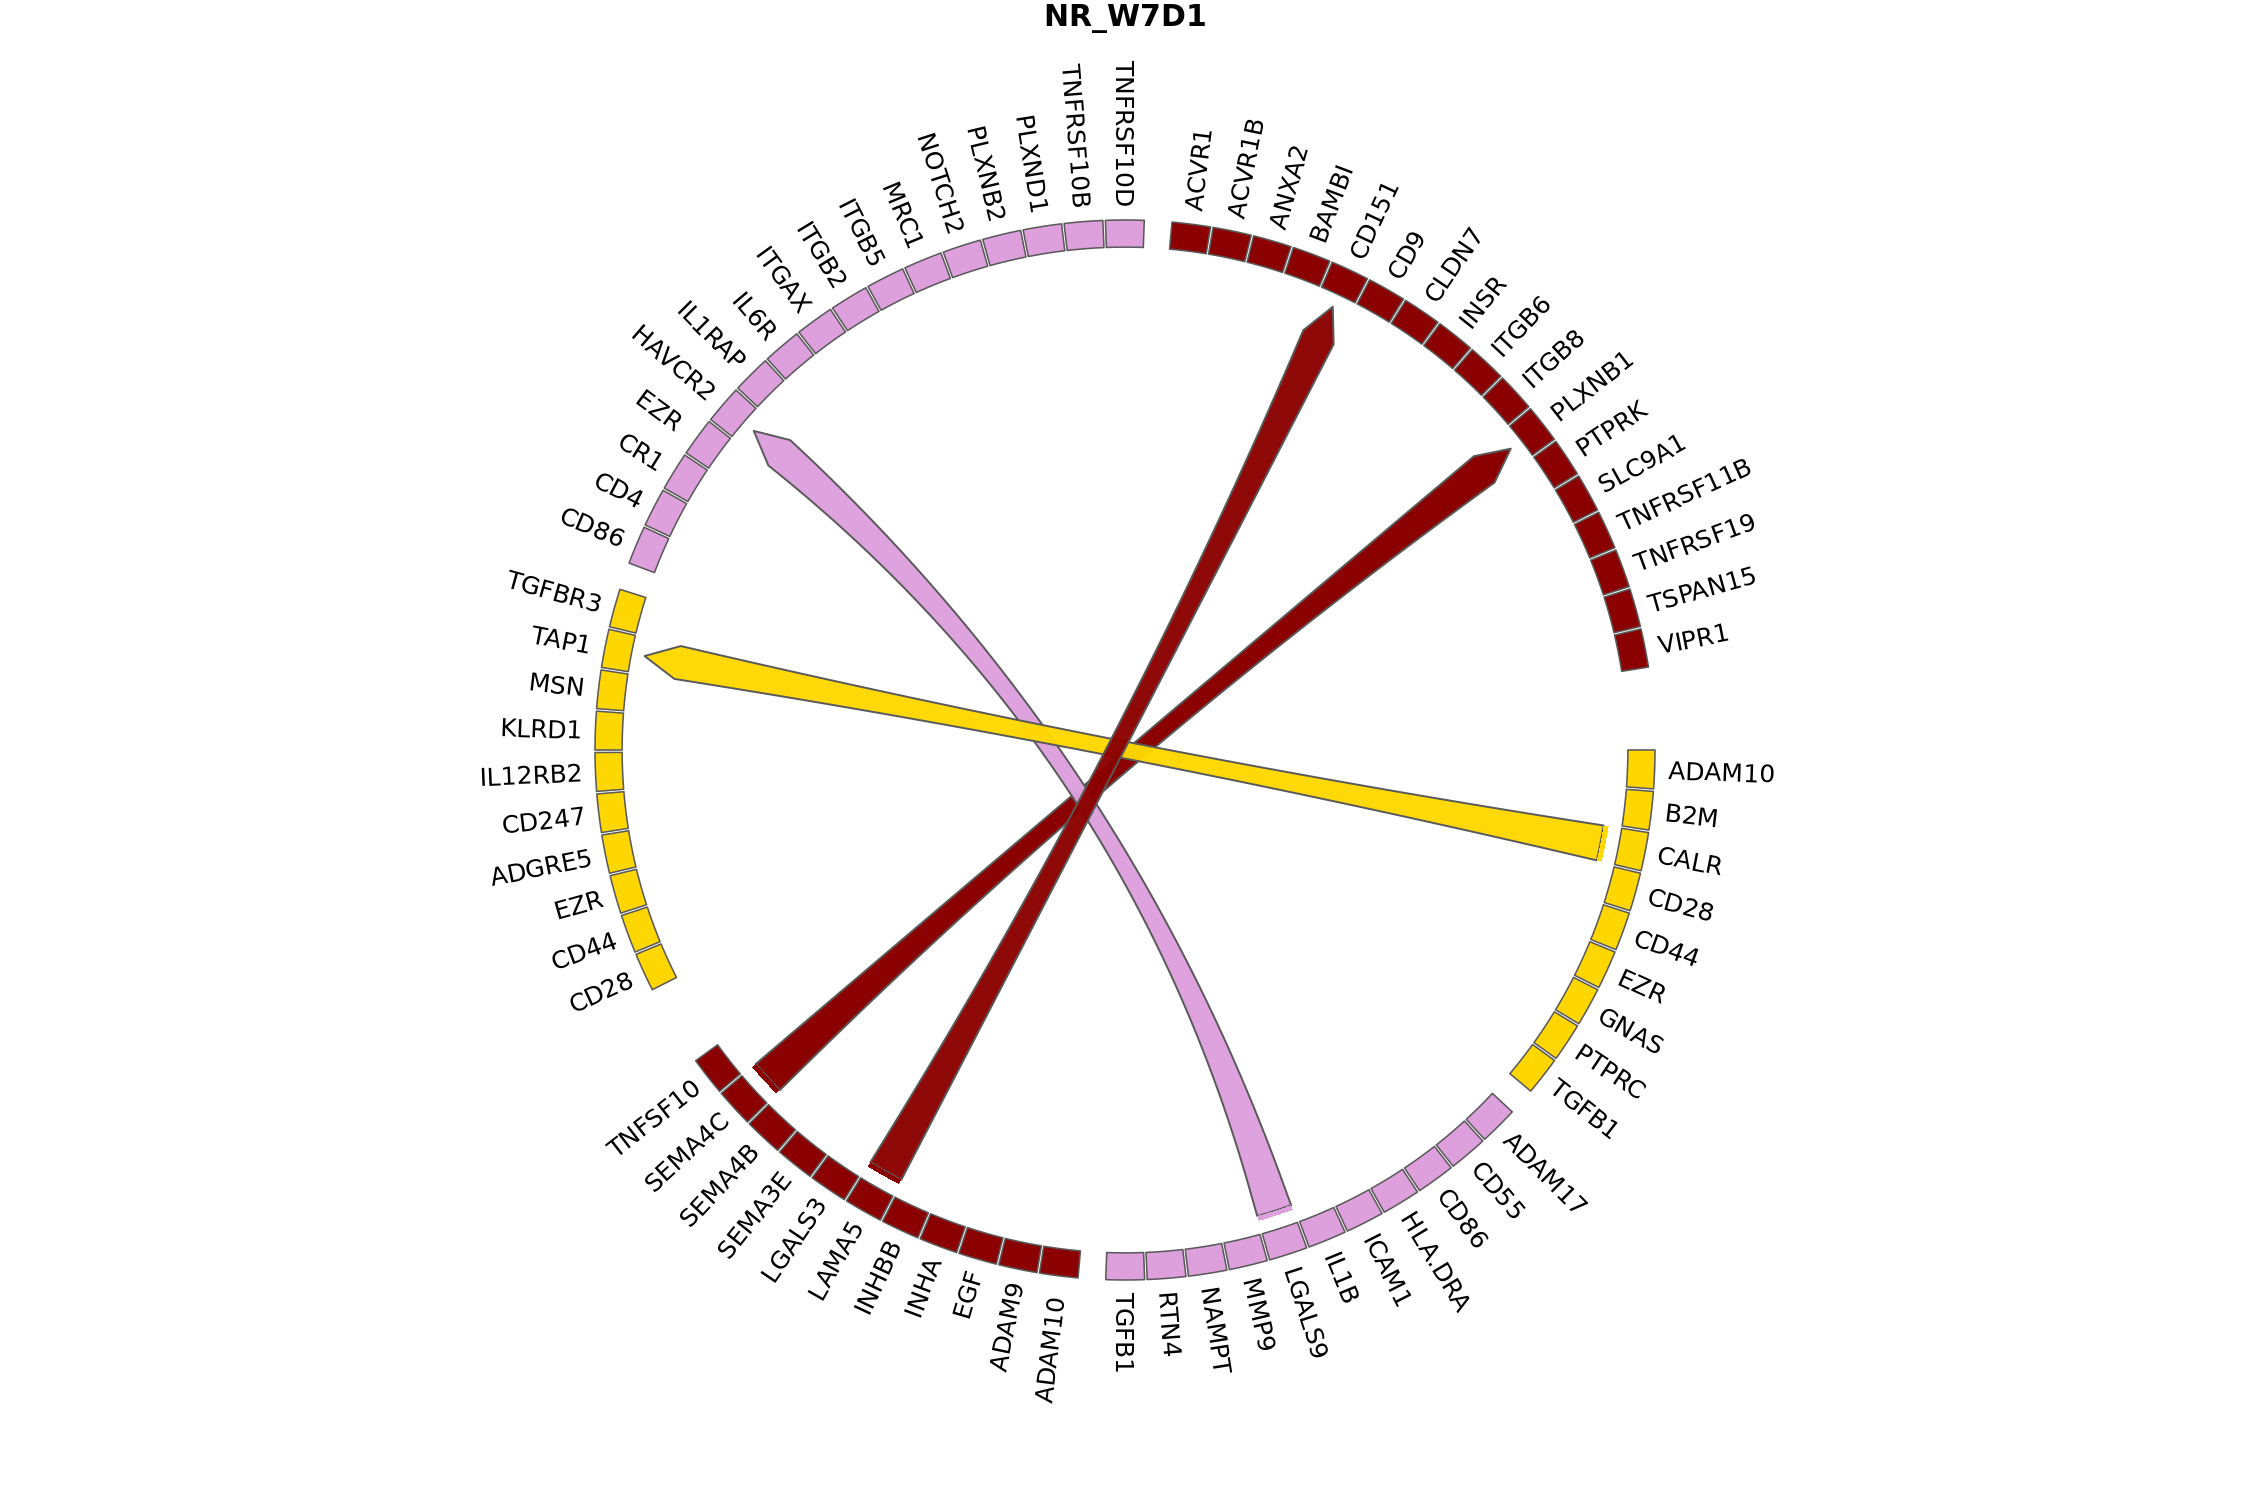

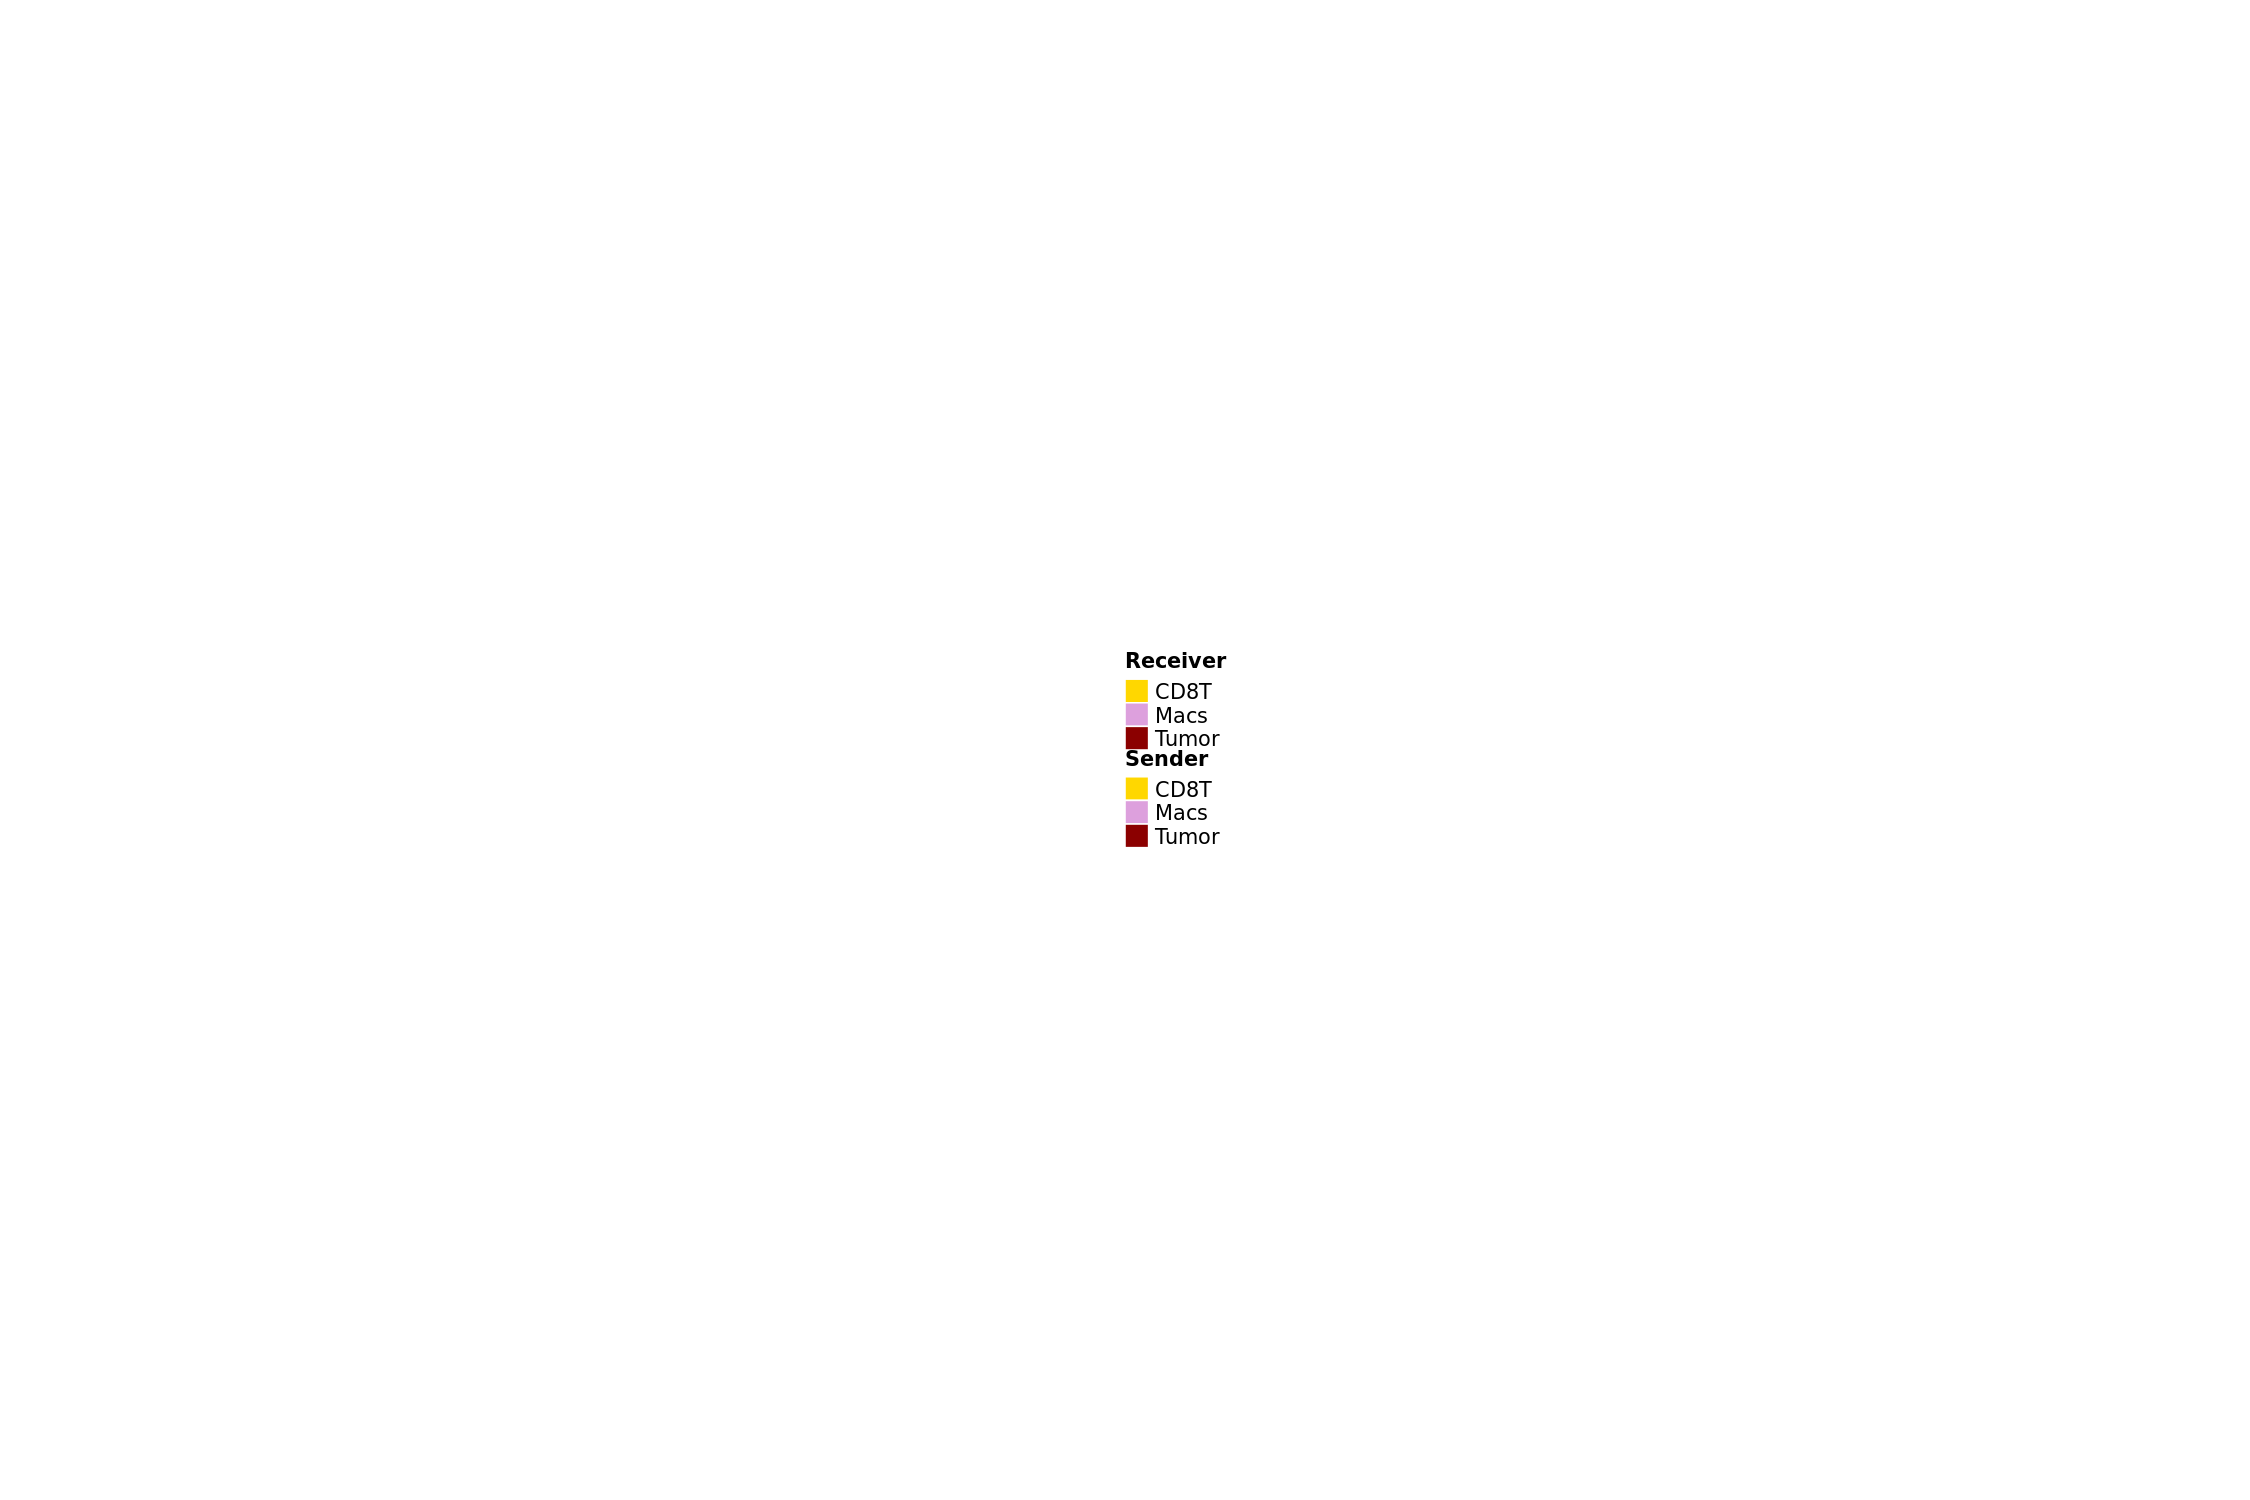

In [57]:
prioritized_tbl_oi_all = get_top_n_lr_pairs(
  multinichenet_output_group1_t2vst1$prioritization_tables, 
  top_n = 50, 
  rank_per_group = FALSE,
    senders_oi = c('CD8T','Macs','Tumor'),
    receivers_oi= c('CD8T','Macs','Tumor')
  )

prioritized_tbl_oi = 
  multinichenet_output_group1_t2vst1$prioritization_tables$group_prioritization_tbl %>%
  filter(id %in% prioritized_tbl_oi_all$id) %>%
  distinct(id, sender, receiver, ligand, receptor, group) %>% 
  left_join(prioritized_tbl_oi_all)
prioritized_tbl_oi$prioritization_score[is.na(prioritized_tbl_oi$prioritization_score)] = 0

senders_receivers = union(prioritized_tbl_oi$sender %>% unique(), prioritized_tbl_oi$receiver %>% unique()) %>% sort()

colors_sender = c()
colors_name = c()
for( celltype in names(COLOR_PAlETTE$Celltype)){
    if(celltype %in% senders_receivers){
        colors_sender  = c(colors_sender ,COLOR_PAlETTE$Celltype[[celltype]])
        colors_name = c(colors_name,celltype)
        }
}
colors_sender = colors_sender %>% magrittr::set_names(colors_name)
colors_receiver = colors_sender

circos_list = make_circos_group_comparison(prioritized_tbl_oi, colors_sender, colors_receiver)
